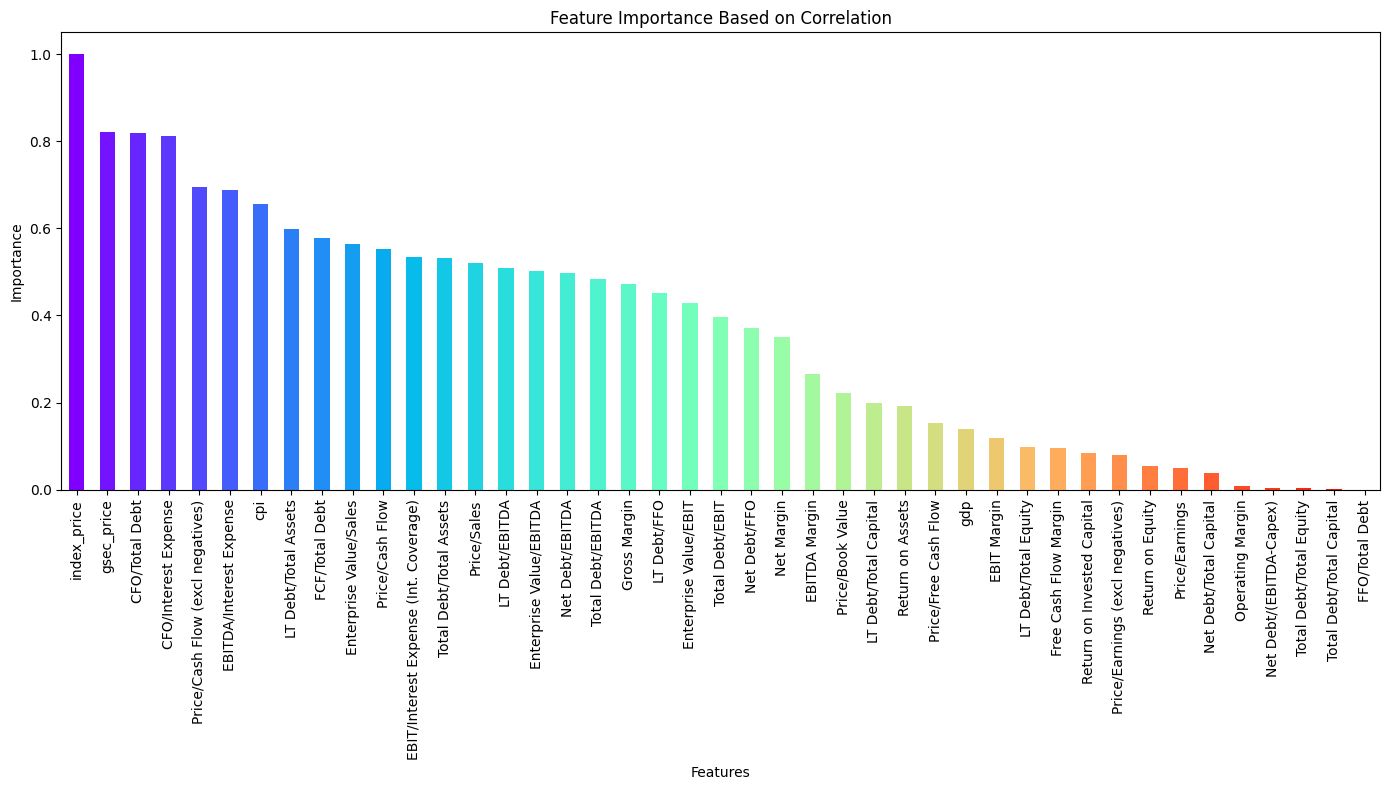

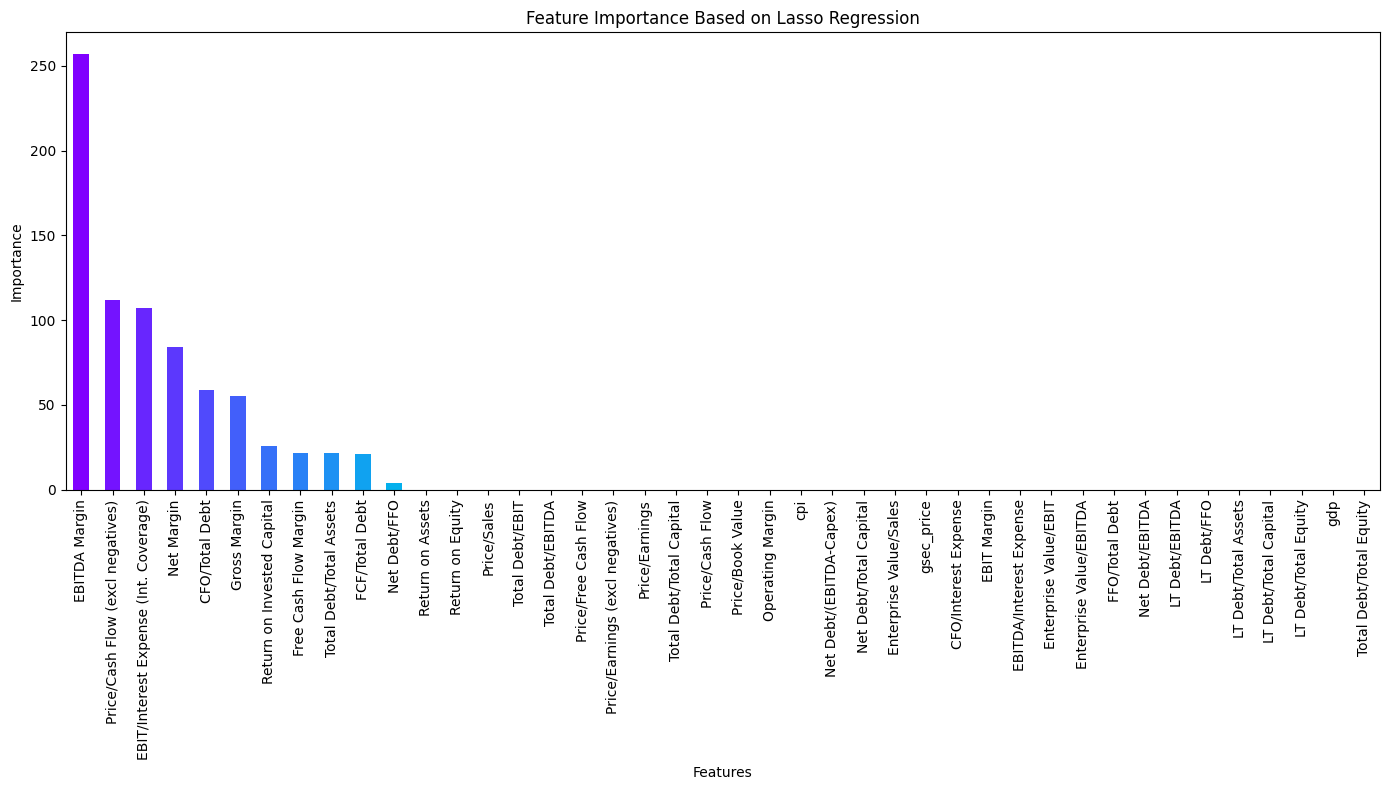

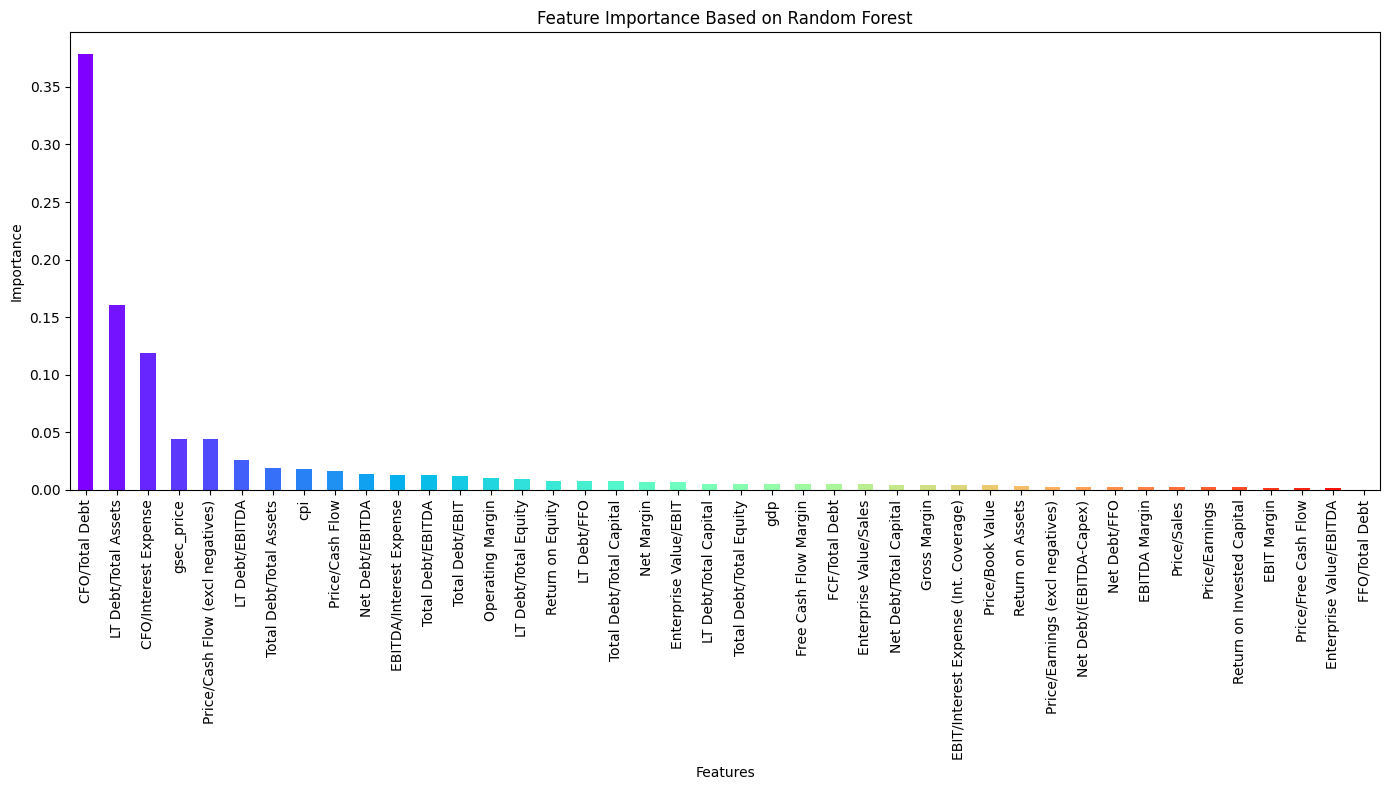

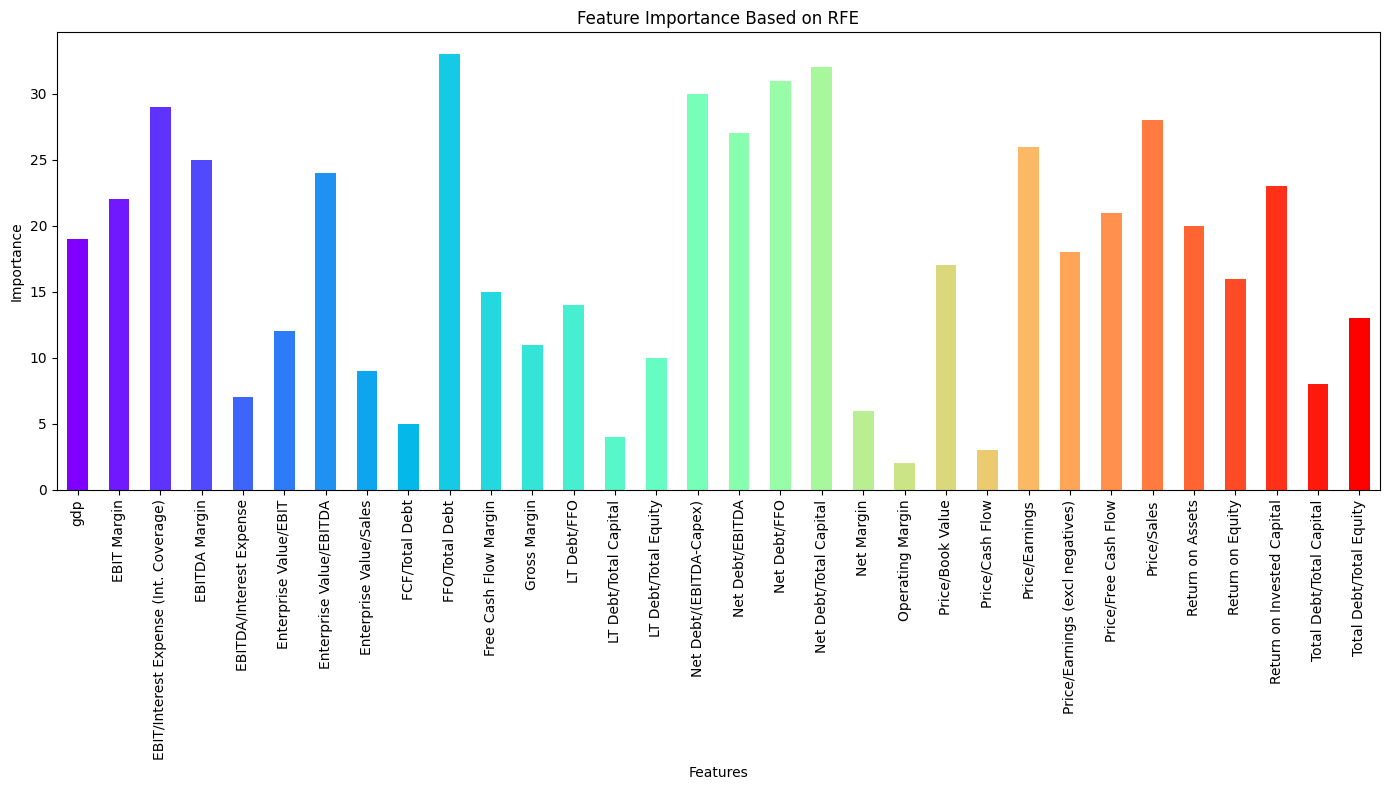

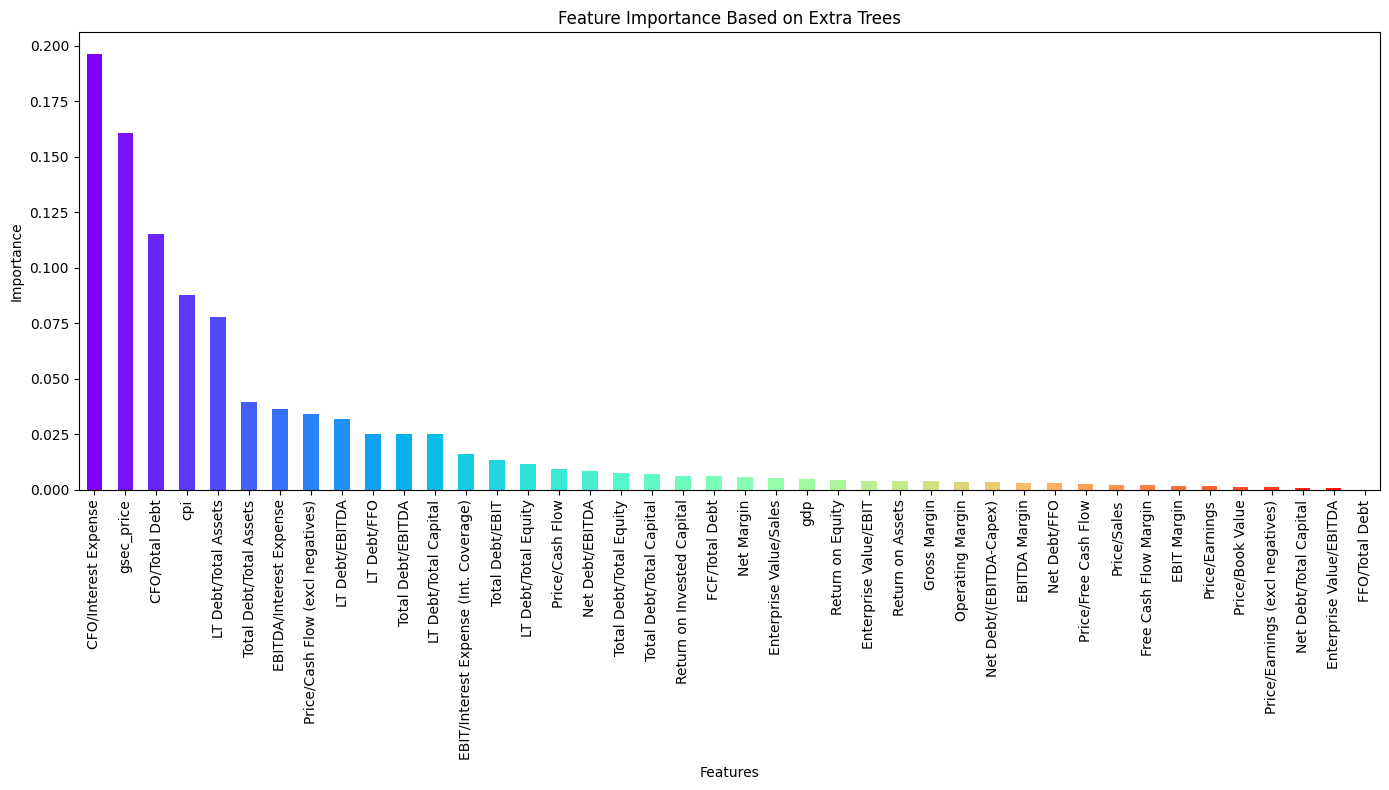

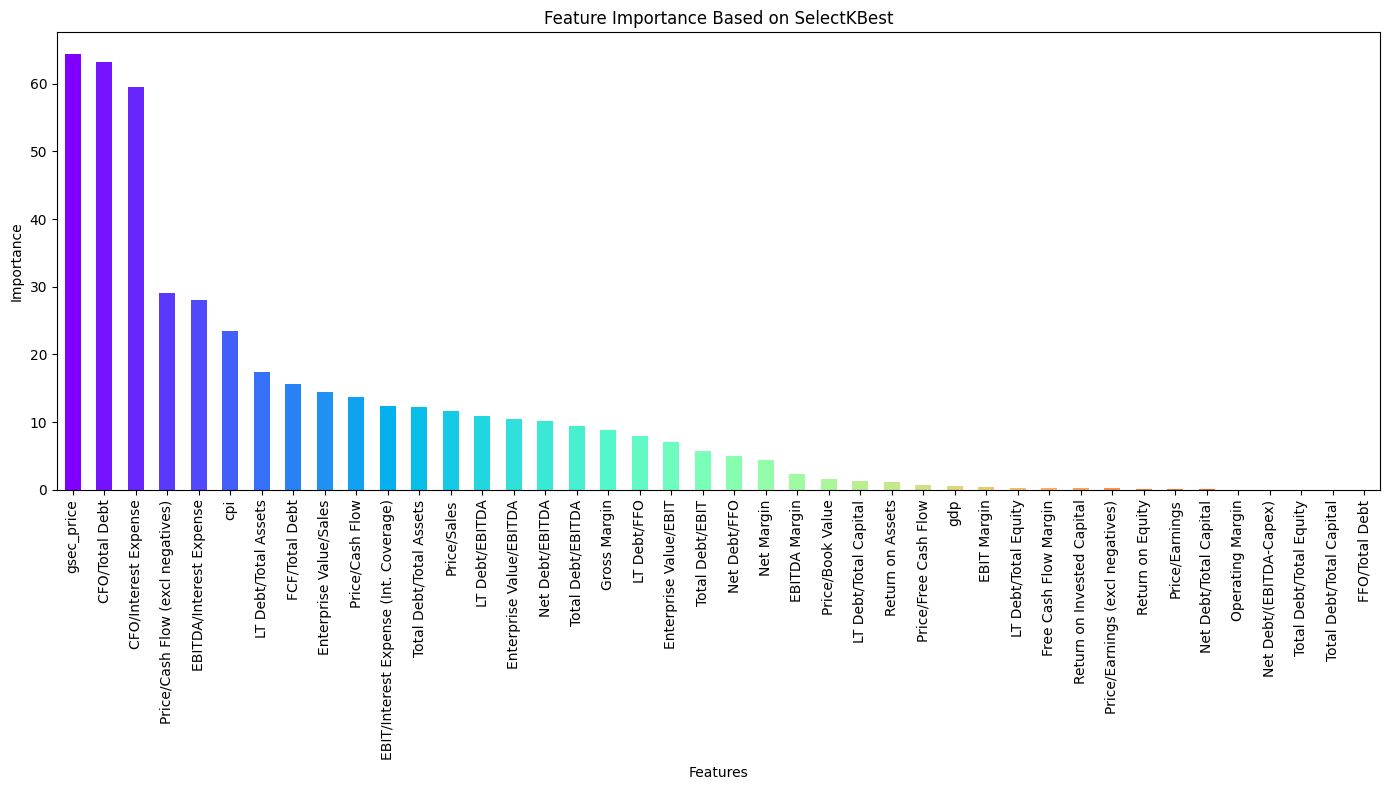

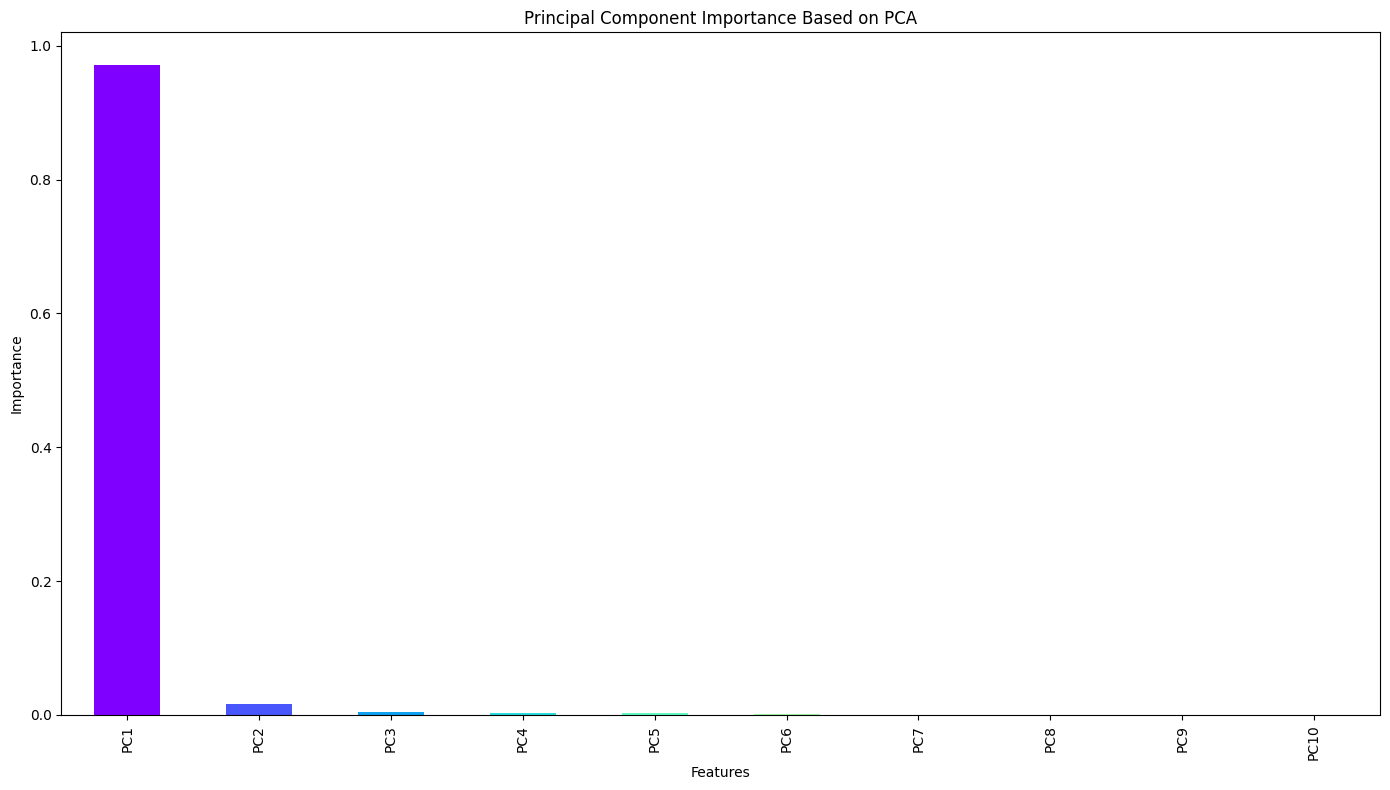

{'Correlation': index_price                              1.000000
 gsec_price                               0.821541
 CFO/Total Debt                           0.819033
 CFO/Interest Expense                     0.810988
 Price/Cash Flow (excl negatives)         0.695764
 EBITDA/Interest Expense                  0.689138
 cpi                                      0.656129
 LT Debt/Total Assets                     0.598771
 FCF/Total Debt                           0.578759
 Enterprise Value/Sales                   0.562977
 Price/Cash Flow                          0.553599
 EBIT/Interest Expense (Int. Coverage)    0.533230
 Total Debt/Total Assets                  0.531601
 Price/Sales                              0.521168
 LT Debt/EBITDA                           0.509574
 Enterprise Value/EBITDA                  0.502582
 Net Debt/EBITDA                          0.496673
 Total Debt/EBITDA                        0.483237
 Gross Margin                             0.471409
 LT Debt/FFO    

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from feature_engine.outliers import Winsorizer
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.feature_selection import mutual_info_regression, RFE, SelectKBest, f_regression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'updated_Japan_file.csv'
data = pd.read_csv(file_path)

# Identify skewed features
skewed_features = data.drop(columns=['quarter_date', 'benchmark_price', 'index_price']).apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[abs(skewed_features) > 0.5].index

# Winsorize skewed features
winsor = Winsorizer(capping_method='iqr', tail='both', fold=1.5)
data[skewed_features] = winsor.fit_transform(data[skewed_features])

# Standardize skewed features
scaler = StandardScaler()
data[skewed_features] = scaler.fit_transform(data[skewed_features])

# Apply transformations (log, sqrt)
for feature in skewed_features:
    if any(data[feature] <= 0):
        data[feature] = np.sqrt(data[feature] - data[feature].min() + 1)
    else:
        data[feature] = np.log1p(data[feature])

# Prepare the dataset for feature selection
X = data.drop(columns=['quarter_date', 'benchmark_price', 'index_price'])
y = data['index_price']

# Correlation Analysis
data.drop(columns=['quarter_date'], inplace=True)
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['index_price'].abs().sort_values(ascending=False).drop('benchmark_price')

# Lasso Regression
lasso = LassoCV(cv=5).fit(X, y)
lasso_importance = pd.Series(lasso.coef_, index=X.columns).abs().sort_values(ascending=False)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)
rf_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Mutual Information Regression
mi = mutual_info_regression(X, y)
mi_importance = pd.Series(mi, index=X.columns).sort_values(ascending=False)

# Recursive Feature Elimination (RFE)
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=10).fit(X, y)
rfe_importance = pd.Series(rfe.ranking_, index=X.columns)

# Extra Trees Regressor
etr = ExtraTreesRegressor(n_estimators=100, random_state=42).fit(X, y)
etr_importance = pd.Series(etr.feature_importances_, index=X.columns).sort_values(ascending=False)

# SelectKBest with f_regression
skb = SelectKBest(score_func=f_regression, k=10).fit(X, y)
skb_importance = pd.Series(skb.scores_, index=X.columns).sort_values(ascending=False)

# Principal Component Analysis (PCA)
pca = PCA(n_components=10).fit(X)
pca_importance = pd.Series(pca.explained_variance_ratio_, index=[f'PC{i+1}' for i in range(10)])

# Plotting the feature importances
def plot_feature_importances(importances, title, top_n=None):
    plt.figure(figsize=(14, 8))
    if top_n:
        importances = importances.head(top_n)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(importances)))  # Rainbow color scheme
    importances.plot(kind='bar', rot=90, color=colors)
    plt.title(title)
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.show()

# Plot all features for each method
plot_feature_importances(correlation_with_target, 'Feature Importance Based on Correlation')

plot_feature_importances(lasso_importance, 'Feature Importance Based on Lasso Regression')

plot_feature_importances(rf_importance, 'Feature Importance Based on Random Forest')


plot_feature_importances(rfe_importance.replace({1: np.nan, 0: 1}).dropna(), 'Feature Importance Based on RFE')

plot_feature_importances(etr_importance, 'Feature Importance Based on Extra Trees')

plot_feature_importances(skb_importance, 'Feature Importance Based on SelectKBest')

plot_feature_importances(pca_importance, 'Principal Component Importance Based on PCA')

# Display the top features from each method
top_features = {
    "Correlation": correlation_with_target,
    "Lasso Regression": lasso_importance,
    "Random Forest": rf_importance,
    "RFE": rfe_importance[rfe_importance == 1],
    "Extra Trees": etr_importance,
    "SelectKBest": skb_importance,
    "PCA": pca_importance,
}

top_features

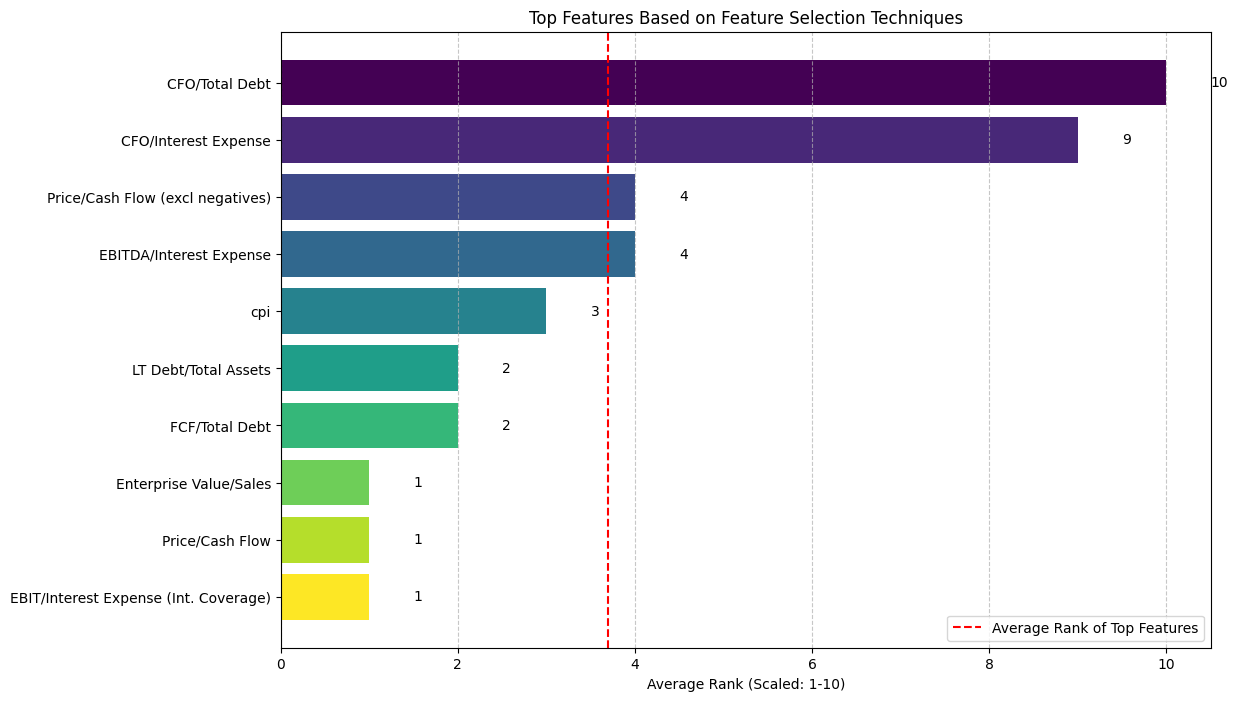

Average rank of top features: 3.70


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Features and their average ranks based on the provided output data
features = [
    'CFO/Total Debt', 'CFO/Interest Expense', 'Price/Cash Flow (excl negatives)',
    'EBITDA/Interest Expense', 'cpi', 'LT Debt/Total Assets', 'FCF/Total Debt',
    'Enterprise Value/Sales', 'Price/Cash Flow', 'EBIT/Interest Expense (Int. Coverage)',
    'Total Debt/Total Assets', 'Price/Sales', 'LT Debt/EBITDA', 'Enterprise Value/EBITDA',
    'Net Debt/EBITDA', 'Total Debt/EBITDA', 'Gross Margin', 'LT Debt/FFO',
    'Enterprise Value/EBIT', 'Total Debt/EBIT', 'Net Debt/FFO', 'Net Margin',
    'EBITDA Margin', 'Price/Book Value', 'LT Debt/Total Capital', 'Return on Assets',
    'Price/Free Cash Flow', 'gdp', 'EBIT Margin', 'LT Debt/Total Equity',
    'Free Cash Flow Margin', 'Return on Invested Capital', 'Price/Earnings (excl negatives)',
    'Return on Equity', 'Price/Earnings', 'Net Debt/Total Capital', 'Operating Margin',
    'Net Debt/(EBITDA-Capex)', 'Total Debt/Total Equity', 'Total Debt/Total Capital'
]

average_ranks = [
    63.2, 59.6, 29.1, 28.0, 23.4, 17.3, 15.6, 14.4, 13.7, 12.3,
    12.2, 11.6, 10.9, 10.5, 10.2, 9.4, 8.9, 7.9, 7.0, 5.8,
    5.0, 4.4, 2.4, 1.6, 1.3, 1.2, 1.2, 0.9, 0.7, 0.6, 0.4,
    0.3, 0.2, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0
]

# Select the top 10 most impactful features
top_features = [
    'CFO/Total Debt', 'CFO/Interest Expense', 'Price/Cash Flow (excl negatives)',
    'EBITDA/Interest Expense', 'cpi', 'LT Debt/Total Assets', 'FCF/Total Debt',
    'Enterprise Value/Sales', 'Price/Cash Flow', 'EBIT/Interest Expense (Int. Coverage)'
]
top_ranks = [
    63.2, 59.6, 29.1, 28.0, 23.4, 17.3, 15.6, 14.4, 13.7, 12.3
]

# Normalize ranks to a range of 1 to 10
min_rank = min(top_ranks)
max_rank = max(top_ranks)
scaled_ranks = [(rank - min_rank) / (max_rank - min_rank) * 9 + 1 for rank in top_ranks]
scaled_ranks = [round(rank) for rank in scaled_ranks]

# Calculate the average rank of the selected features
average_of_top_ranks = np.mean(scaled_ranks)

# Plotting
plt.figure(figsize=(12, 8))
plt.axvline(x=average_of_top_ranks, color='red', linestyle='--', label='Average Rank of Top Features')
plt.barh(top_features, scaled_ranks, color=plt.cm.viridis(np.linspace(0, 1, len(top_features))))
plt.xlabel('Average Rank (Scaled: 1-10)')
plt.title('Top Features Based on Feature Selection Techniques')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest rank on top
plt.legend()

# Add labels with values on the bars
for bar, rank in zip(top_features, scaled_ranks):
    plt.text(rank + 0.5, bar, f'{rank}', va='center')

plt.show()

print(f"Average rank of top features: {average_of_top_ranks:.2f}")


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Features and their average ranks based on the provided output data
features = [
    'Return on Invested Capital', 'Return on Assets', 'Net Debt/FFO',
    'Net Debt/EBITDA', 'Net Margin', 'Return on Equity', 'Total Debt/EBITDA',
    'Net Debt/Total Capital', 'Net Debt/(EBITDA-Capex)', 'Total Debt/Total Capital',
    'Price/Book Value', 'CFO/Total Debt', 'EBIT/Interest Expense (Int. Coverage)',
    'EBITDA/Interest Expense', 'Total Debt/Total Equity', 'Total Debt/EBIT',
    'LT Debt/FFO', 'LT Debt/EBITDA', 'LT Debt/Total Equity',
    'Enterprise Value/EBITDA', 'Total Debt/Total Assets',
    'Price/Cash Flow (excl negatives)', 'Free Cash Flow Margin',
    'LT Debt/Total Capital', 'CFO/Interest Expense', 'FCF/Total Debt',
    'Price/Sales', 'LT Debt/Total Assets', 'Price/Free Cash Flow',
    'Enterprise Value/Sales', 'Operating Margin', 'Enterprise Value/EBIT',
    'EBITDA Margin', 'cpi', 'Gross Margin', 'Price/Earnings (excl negatives)',
    'gdp', 'Price/Earnings', 'gsec_price', 'Price/Cash Flow', 'EBIT Margin'
]

average_ranks = [
   1,2,3,4,5,6,7,8,9,10
]

# Selecting top 10 most impacting features
top_features = [
   'CFO/Total Debt',
'gsec_price',
'CFO/Interest Expense',
'Price/Cash Flow (excl negatives)',
'LT Debt/Total Assets',
'Total Debt/Total Assets',
'EBITDA/Interest Expense',
'LT Debt/EBITDA',
'Total Debt/EBITDA',
'cpi'
]
top_ranks = [average_ranks[features.index(feature)] for feature in top_features]

# Sort features and average ranks in ascending order
sorted_indices = np.argsort(top_ranks)
features_sorted = [top_features[i] for i in sorted_indices]
average_ranks_sorted = [top_ranks[i] for i in sorted_indices]

# Define colors for the bars
colors = plt.cm.magma(np.linspace(0, 1, len(top_features)))

# Plotting
plt.figure(figsize=(10, 8))
bars = plt.barh(features_sorted, average_ranks_sorted, color=colors)
plt.xlabel('Average Rank')
plt.title('Top 10 Most Impacting Features Based on Average Rank for Index Price for Japan')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest rank on top

# Add labels with values on the bars
for bar, rank in zip(bars, average_ranks_sorted):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{rank:.1f}', va='center')

plt.show()


IndexError: list index out of range

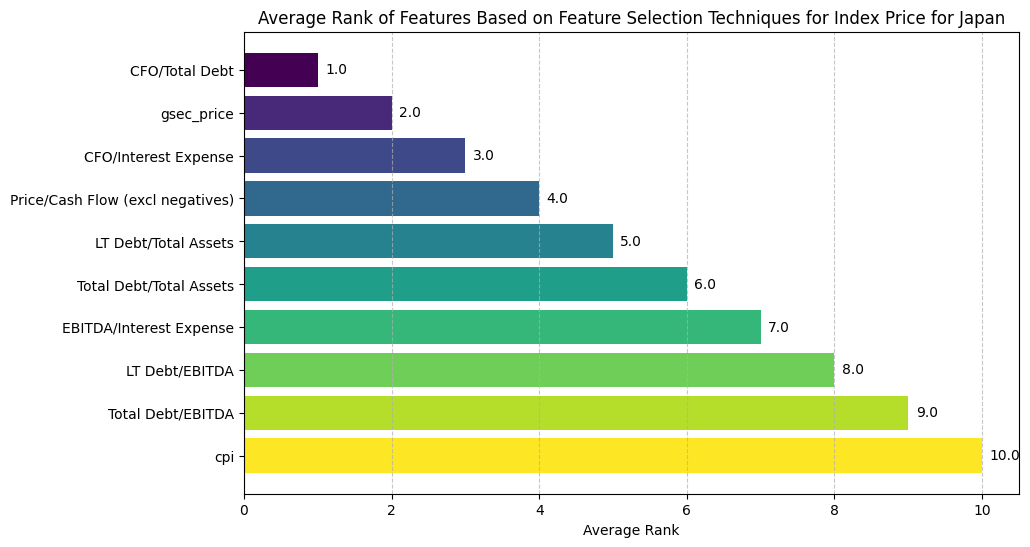

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Features and their average ranks based on provided data
features = [
    'CFO/Total Debt',
    'gsec_price',
    'CFO/Interest Expense',
    'Price/Cash Flow (excl negatives)',
    'LT Debt/Total Assets',
    'Total Debt/Total Assets',
    'EBITDA/Interest Expense',
    'LT Debt/EBITDA',
    'Total Debt/EBITDA',
    'cpi'
]

average_ranks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Sort features and average ranks in ascending order
sorted_indices = np.argsort(average_ranks)
features_sorted = [features[i] for i in sorted_indices]
average_ranks_sorted = [average_ranks[i] for i in sorted_indices]

# Define colors for the bars
colors = plt.cm.viridis(np.linspace(0, 1, len(features)))

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(features_sorted, average_ranks_sorted, color=colors)
plt.xlabel('Average Rank')
plt.title('Average Rank of Features Based on Feature Selection Techniques for Index Price for Japan')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest rank on top

# Add labels with values on the bars
for bar, rank in zip(bars, average_ranks_sorted):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{rank:.1f}', va='center')

plt.show()


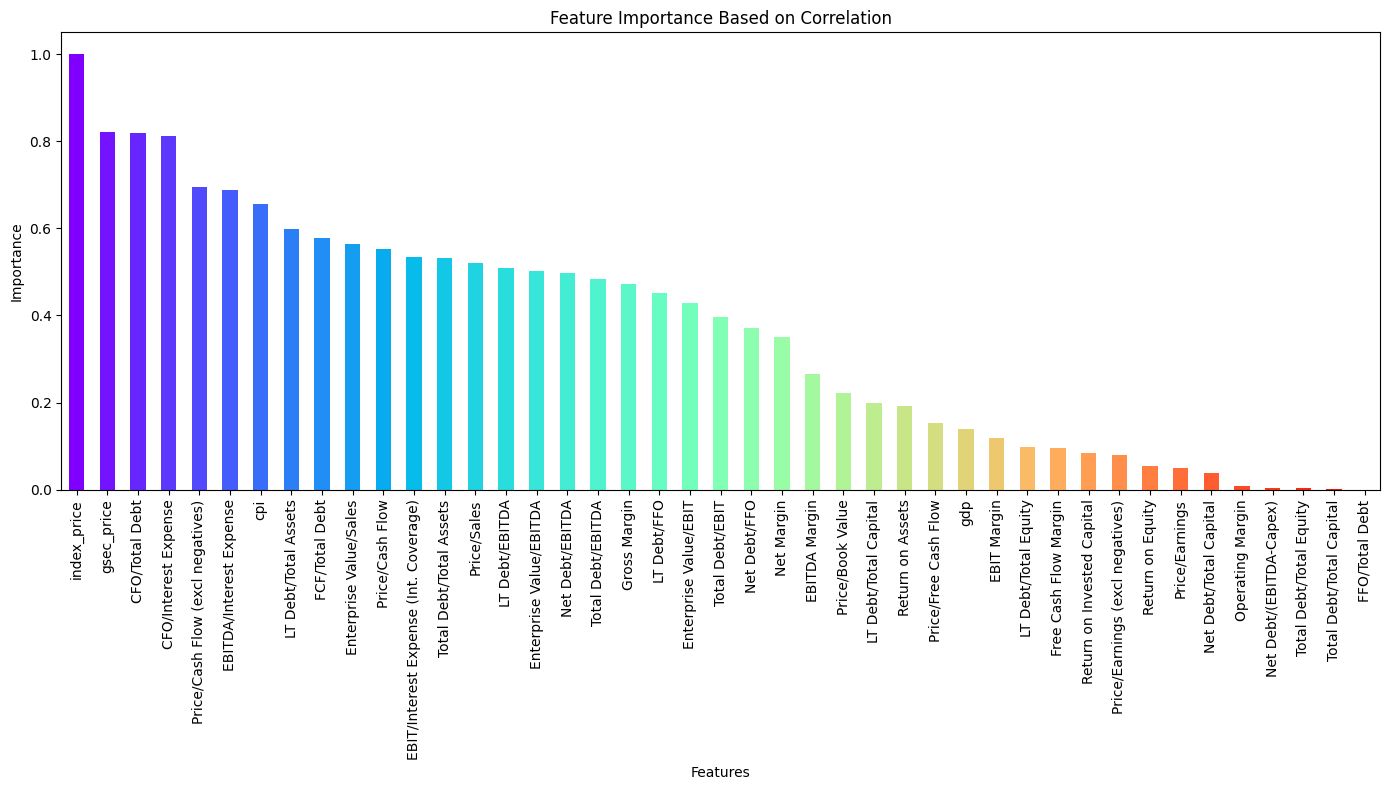

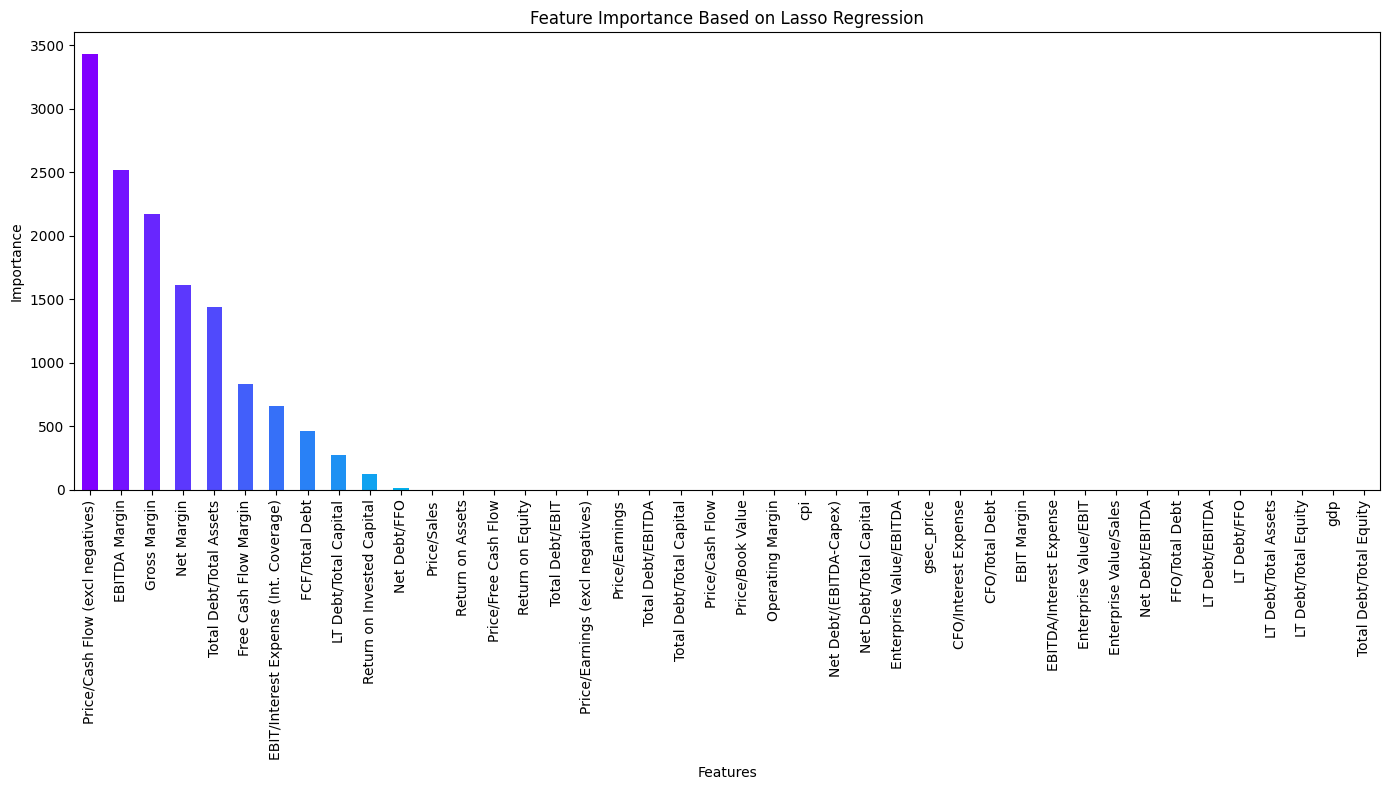

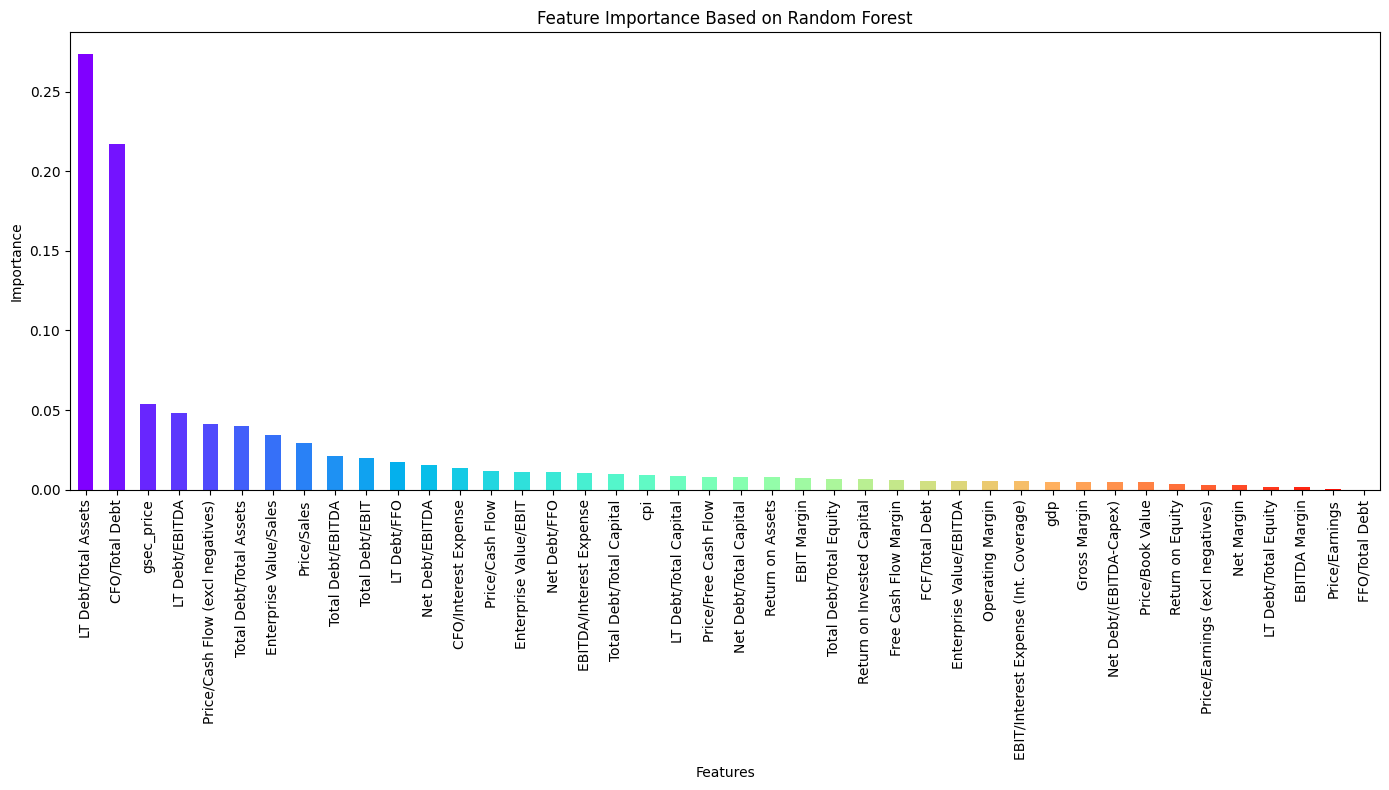

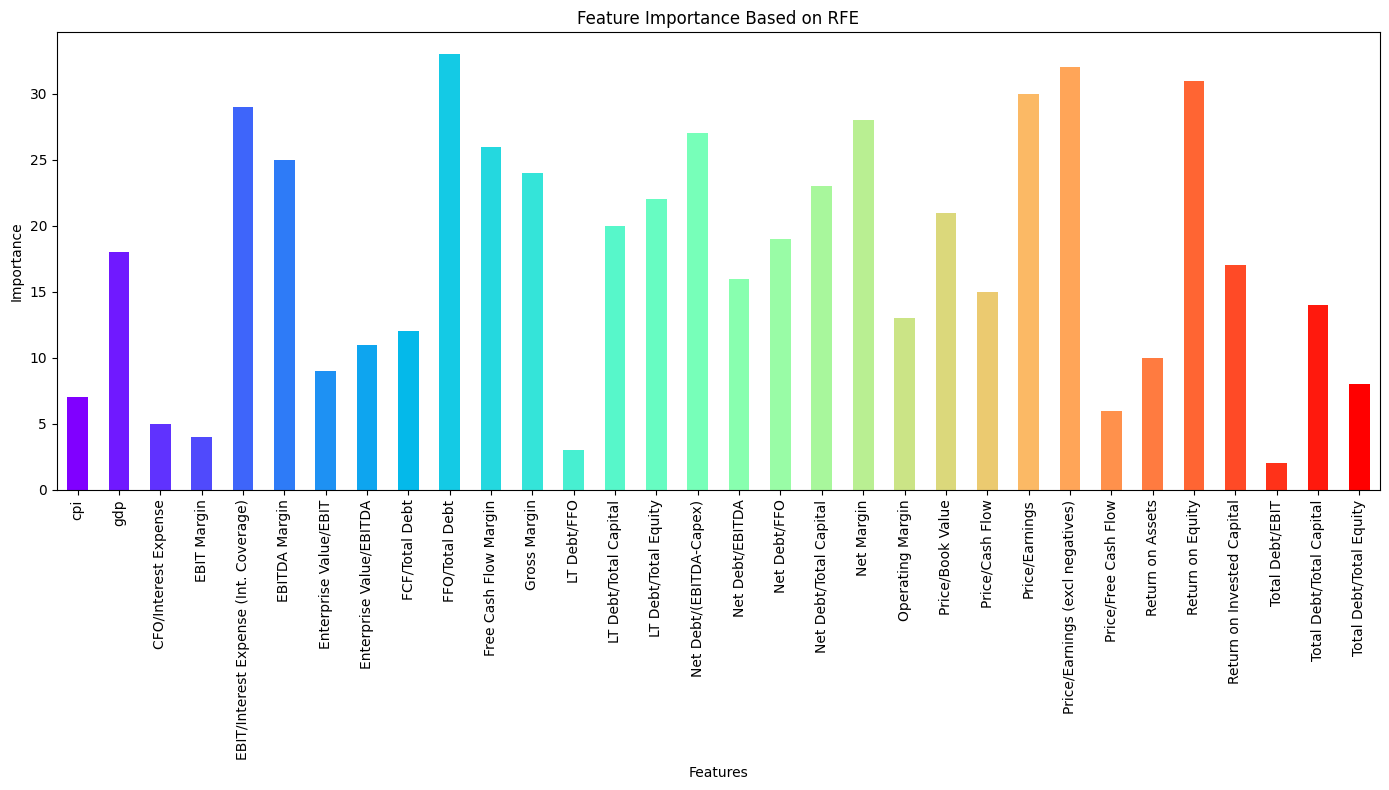

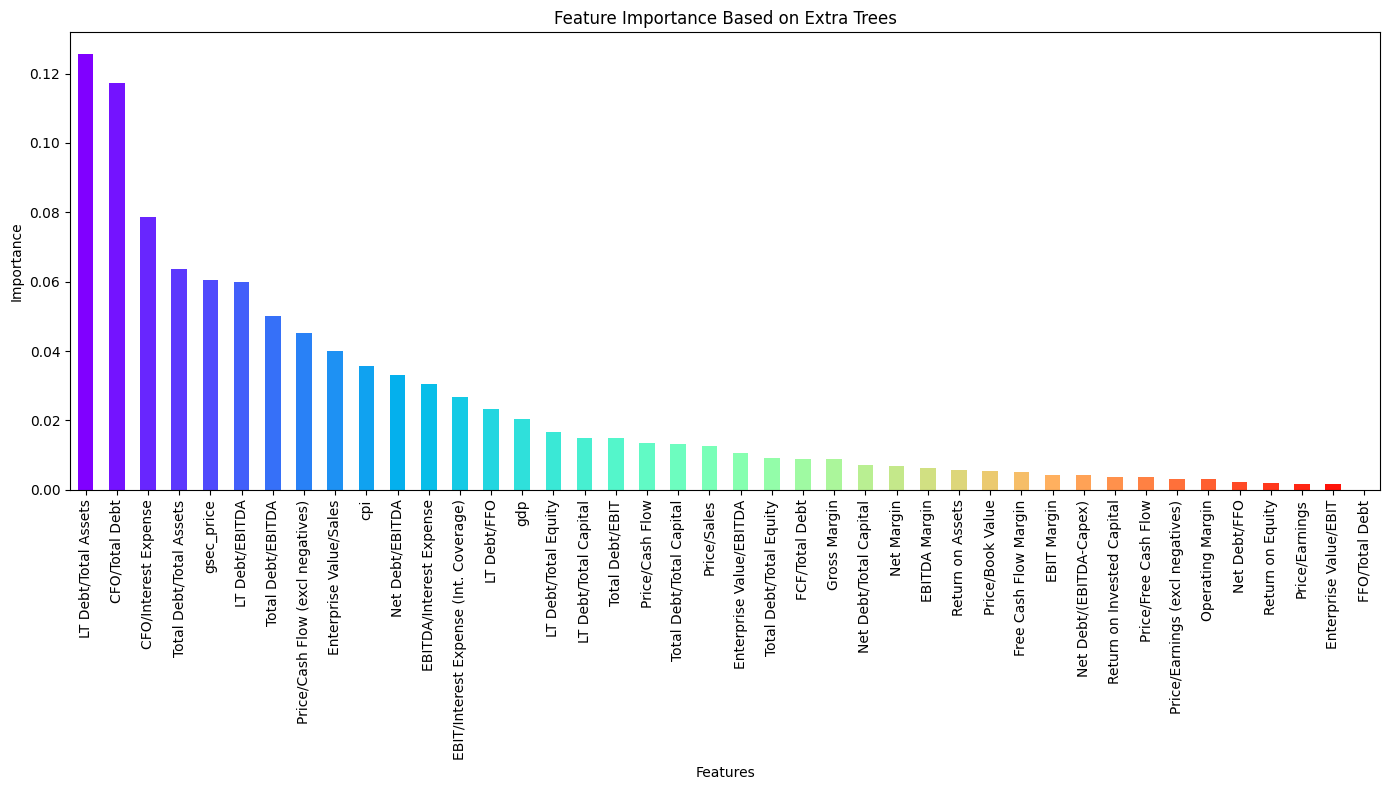

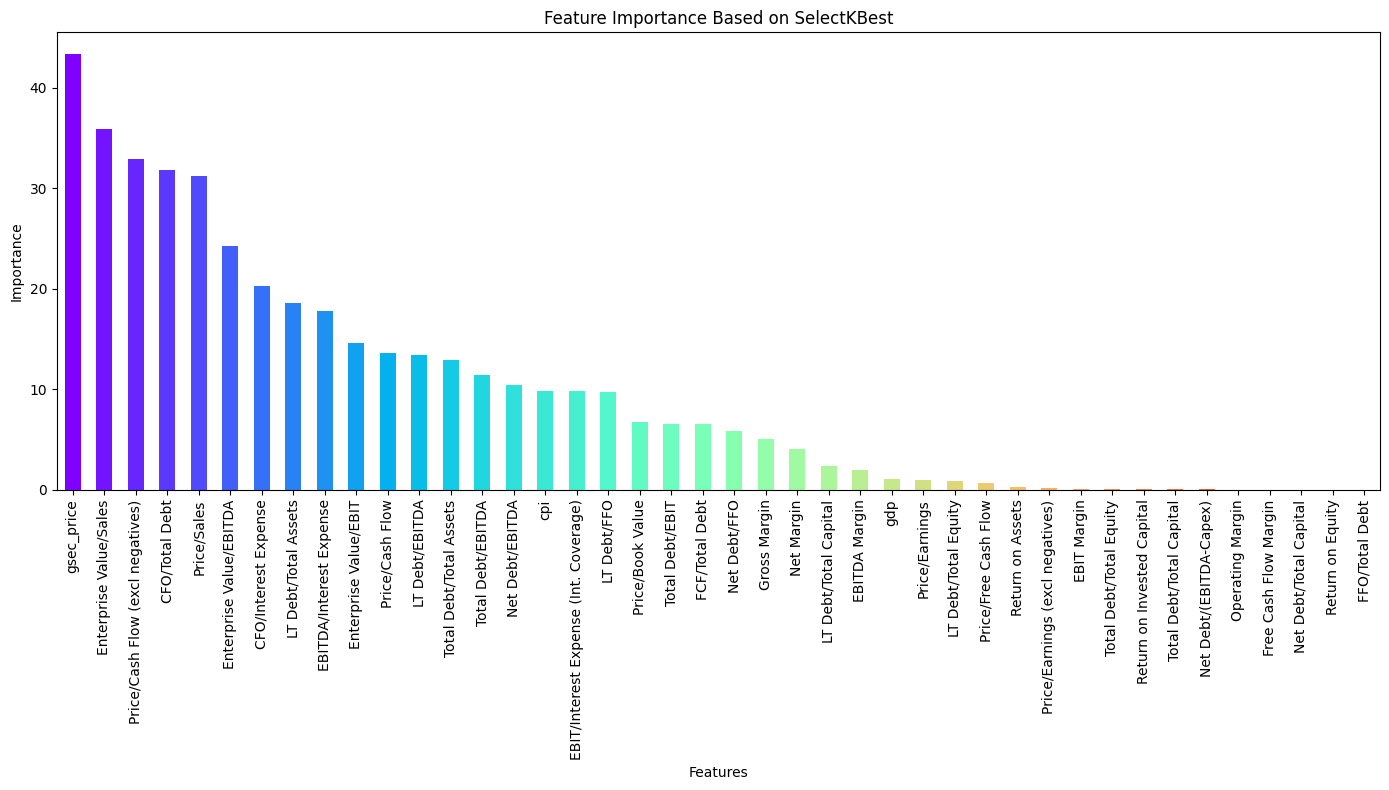

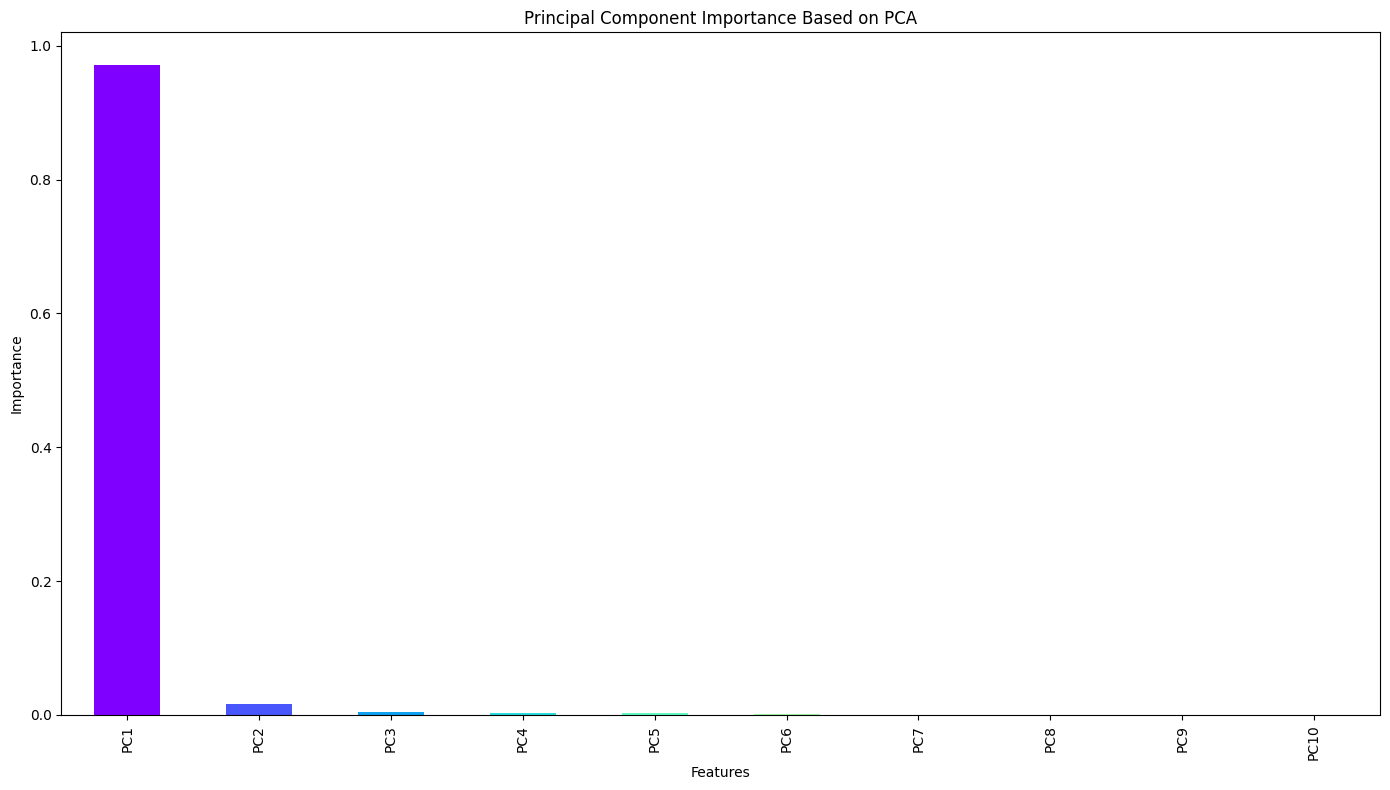

{'Correlation': index_price                              1.000000
 gsec_price                               0.821541
 CFO/Total Debt                           0.819033
 CFO/Interest Expense                     0.810988
 Price/Cash Flow (excl negatives)         0.695764
 EBITDA/Interest Expense                  0.689138
 cpi                                      0.656129
 LT Debt/Total Assets                     0.598771
 FCF/Total Debt                           0.578759
 Enterprise Value/Sales                   0.562977
 Price/Cash Flow                          0.553599
 EBIT/Interest Expense (Int. Coverage)    0.533230
 Total Debt/Total Assets                  0.531601
 Price/Sales                              0.521168
 LT Debt/EBITDA                           0.509574
 Enterprise Value/EBITDA                  0.502582
 Net Debt/EBITDA                          0.496673
 Total Debt/EBITDA                        0.483237
 Gross Margin                             0.471409
 LT Debt/FFO    

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from feature_engine.outliers import Winsorizer
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.feature_selection import mutual_info_regression, RFE, SelectKBest, f_regression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'updated_Japan_file.csv'
data = pd.read_csv(file_path)

# Identify skewed features
skewed_features = data.drop(columns=['quarter_date', 'benchmark_price', 'index_price']).apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[abs(skewed_features) > 0.5].index

# Winsorize skewed features
winsor = Winsorizer(capping_method='iqr', tail='both', fold=1.5)
data[skewed_features] = winsor.fit_transform(data[skewed_features])

# Standardize skewed features
scaler = StandardScaler()
data[skewed_features] = scaler.fit_transform(data[skewed_features])

# Apply transformations (log, sqrt)
for feature in skewed_features:
    if any(data[feature] <= 0):
        data[feature] = np.sqrt(data[feature] - data[feature].min() + 1)
    else:
        data[feature] = np.log1p(data[feature])

# Prepare the dataset for feature selection
X = data.drop(columns=['quarter_date', 'benchmark_price', 'index_price'])
y = data['benchmark_price']

# Correlation Analysis
data.drop(columns=['quarter_date'], inplace=True)
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['index_price'].abs().sort_values(ascending=False).drop('benchmark_price')

# Lasso Regression
lasso = LassoCV(cv=5).fit(X, y)
lasso_importance = pd.Series(lasso.coef_, index=X.columns).abs().sort_values(ascending=False)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)
rf_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Mutual Information Regression
mi = mutual_info_regression(X, y)
mi_importance = pd.Series(mi, index=X.columns).sort_values(ascending=False)

# Recursive Feature Elimination (RFE)
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=10).fit(X, y)
rfe_importance = pd.Series(rfe.ranking_, index=X.columns)

# Extra Trees Regressor
etr = ExtraTreesRegressor(n_estimators=100, random_state=42).fit(X, y)
etr_importance = pd.Series(etr.feature_importances_, index=X.columns).sort_values(ascending=False)

# SelectKBest with f_regression
skb = SelectKBest(score_func=f_regression, k=10).fit(X, y)
skb_importance = pd.Series(skb.scores_, index=X.columns).sort_values(ascending=False)

# Principal Component Analysis (PCA)
pca = PCA(n_components=10).fit(X)
pca_importance = pd.Series(pca.explained_variance_ratio_, index=[f'PC{i+1}' for i in range(10)])

# Plotting the feature importances
def plot_feature_importances(importances, title, top_n=None):
    plt.figure(figsize=(14, 8))
    if top_n:
        importances = importances.head(top_n)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(importances)))  # Rainbow color scheme
    importances.plot(kind='bar', rot=90, color=colors)
    plt.title(title)
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.show()

# Plot all features for each method
plot_feature_importances(correlation_with_target, 'Feature Importance Based on Correlation')

plot_feature_importances(lasso_importance, 'Feature Importance Based on Lasso Regression')

plot_feature_importances(rf_importance, 'Feature Importance Based on Random Forest')


plot_feature_importances(rfe_importance.replace({1: np.nan, 0: 1}).dropna(), 'Feature Importance Based on RFE')

plot_feature_importances(etr_importance, 'Feature Importance Based on Extra Trees')

plot_feature_importances(skb_importance, 'Feature Importance Based on SelectKBest')

plot_feature_importances(pca_importance, 'Principal Component Importance Based on PCA')

# Display the top features from each method
top_features = {
    "Correlation": correlation_with_target,
    "Lasso Regression": lasso_importance,
    "Random Forest": rf_importance,
    "RFE": rfe_importance[rfe_importance == 1],
    "Extra Trees": etr_importance,
    "SelectKBest": skb_importance,
    "PCA": pca_importance,
}

top_features

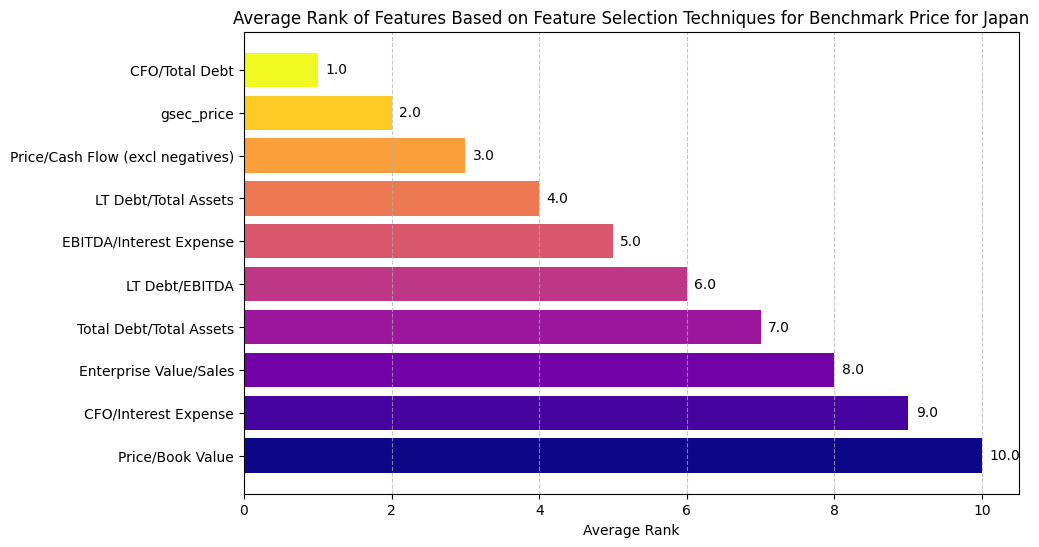

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Features and their average ranks based on provided data
features = [
    'CFO/Total Debt',
    'gsec_price',
    'Price/Cash Flow (excl negatives)',
    'LT Debt/Total Assets',
    'EBITDA/Interest Expense',
    'LT Debt/EBITDA',
    'Total Debt/Total Assets',
    'Enterprise Value/Sales',
    'CFO/Interest Expense',
    'Price/Book Value'
]

average_ranks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Sort features and average ranks in ascending order
sorted_indices = np.argsort(average_ranks)
features_sorted = [features[i] for i in sorted_indices]
average_ranks_sorted = [average_ranks[i] for i in sorted_indices]

# Define colors for the bars using a darker colormap
colors = plt.cm.plasma_r(np.linspace(0, 1, len(features)))

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(features_sorted, average_ranks_sorted, color=colors)
plt.xlabel('Average Rank')
plt.title('Average Rank of Features Based on Feature Selection Techniques for Benchmark Price for Japan')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest rank on top

# Add labels with values on the bars
for bar, rank in zip(bars, average_ranks_sorted):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{rank:.1f}', va='center')

plt.show()


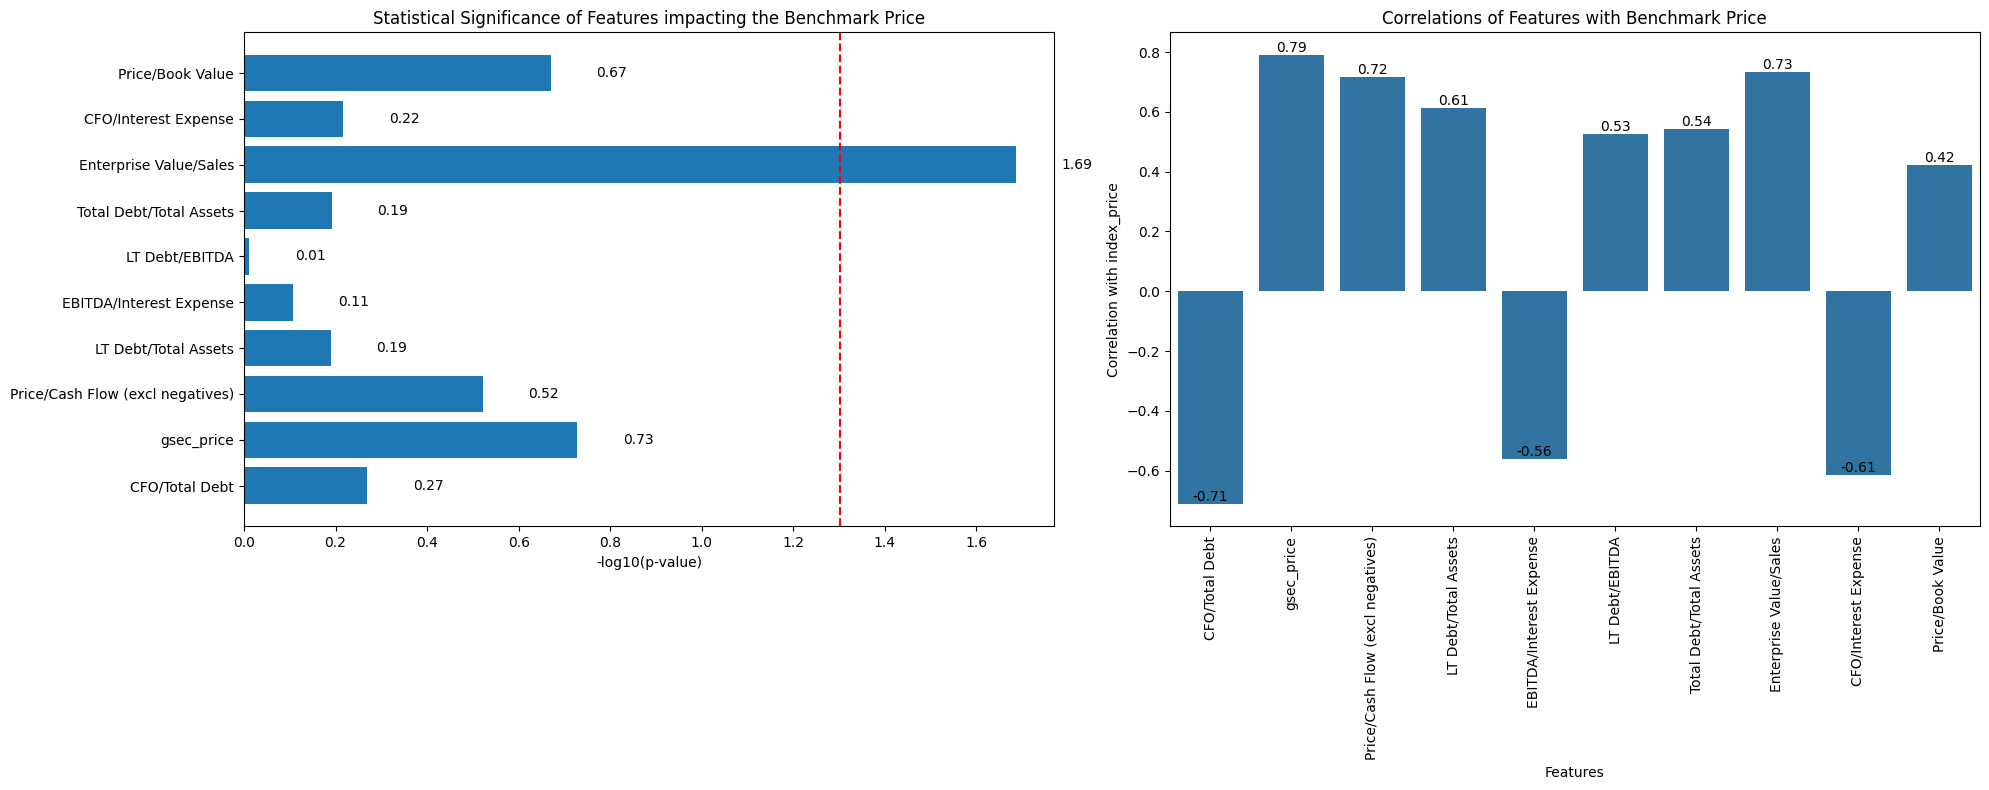

                            OLS Regression Results                            
Dep. Variable:        benchmark_price   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     20.82
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           5.74e-09
Time:                        11:21:15   Log-Likelihood:                -292.19
No. Observations:                  33   AIC:                             606.4
Df Residuals:                      22   BIC:                             622.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame with relevant columns for OLS
df = pd.read_csv('updated_Japan_file.csv')

# Selecting relevant features for OLS
selected_features = ['CFO/Total Debt',
    'gsec_price',
    'Price/Cash Flow (excl negatives)',
    'LT Debt/Total Assets',
    'EBITDA/Interest Expense',
    'LT Debt/EBITDA',
    'Total Debt/Total Assets',
    'Enterprise Value/Sales',
    'CFO/Interest Expense',
    'Price/Book Value'
]
X = sm.add_constant(df[selected_features])  # Including intercept

# Target variable
y = df['benchmark_price']

# Fit OLS model
model = sm.OLS(y, X)
results = model.fit()

# Extract p-values
p_values = results.pvalues.drop('const')  # Excluding the intercept

# Compute correlations
correlations = df[selected_features].corrwith(df['benchmark_price'])

# Plot p-values and correlations side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot p-values
ax[0].barh(selected_features, -np.log10(p_values))
ax[0].set_xlabel('-log10(p-value)')
ax[0].set_title('Statistical Significance of Features impacting the Benchmark Price')
ax[0].axvline(x=-np.log10(0.05), color='red', linestyle='--')
for i, (feature, p_value) in enumerate(p_values.items()):
    ax[0].text(-np.log10(p_value) + 0.1, i, f'{-np.log10(p_value):.2f}', va='center')

# Plot correlations
sns.barplot(x=correlations.index, y=correlations.values, ax=ax[1])
ax[1].set_xlabel('Features')
ax[1].set_ylabel('Correlation with index_price')
ax[1].set_title('Correlations of Features with Benchmark Price')
ax[1].tick_params(axis='x', rotation=90)
for i, (feature, correlation) in enumerate(correlations.items()):
    ax[1].text(i, correlation + 0.01, f'{correlation:.2f}', ha='center')

plt.tight_layout()
plt.savefig('Statistical_Significance_and_Correlations.png', bbox_inches='tight')
plt.show()

# Print summary of regression results
print(results.summary())


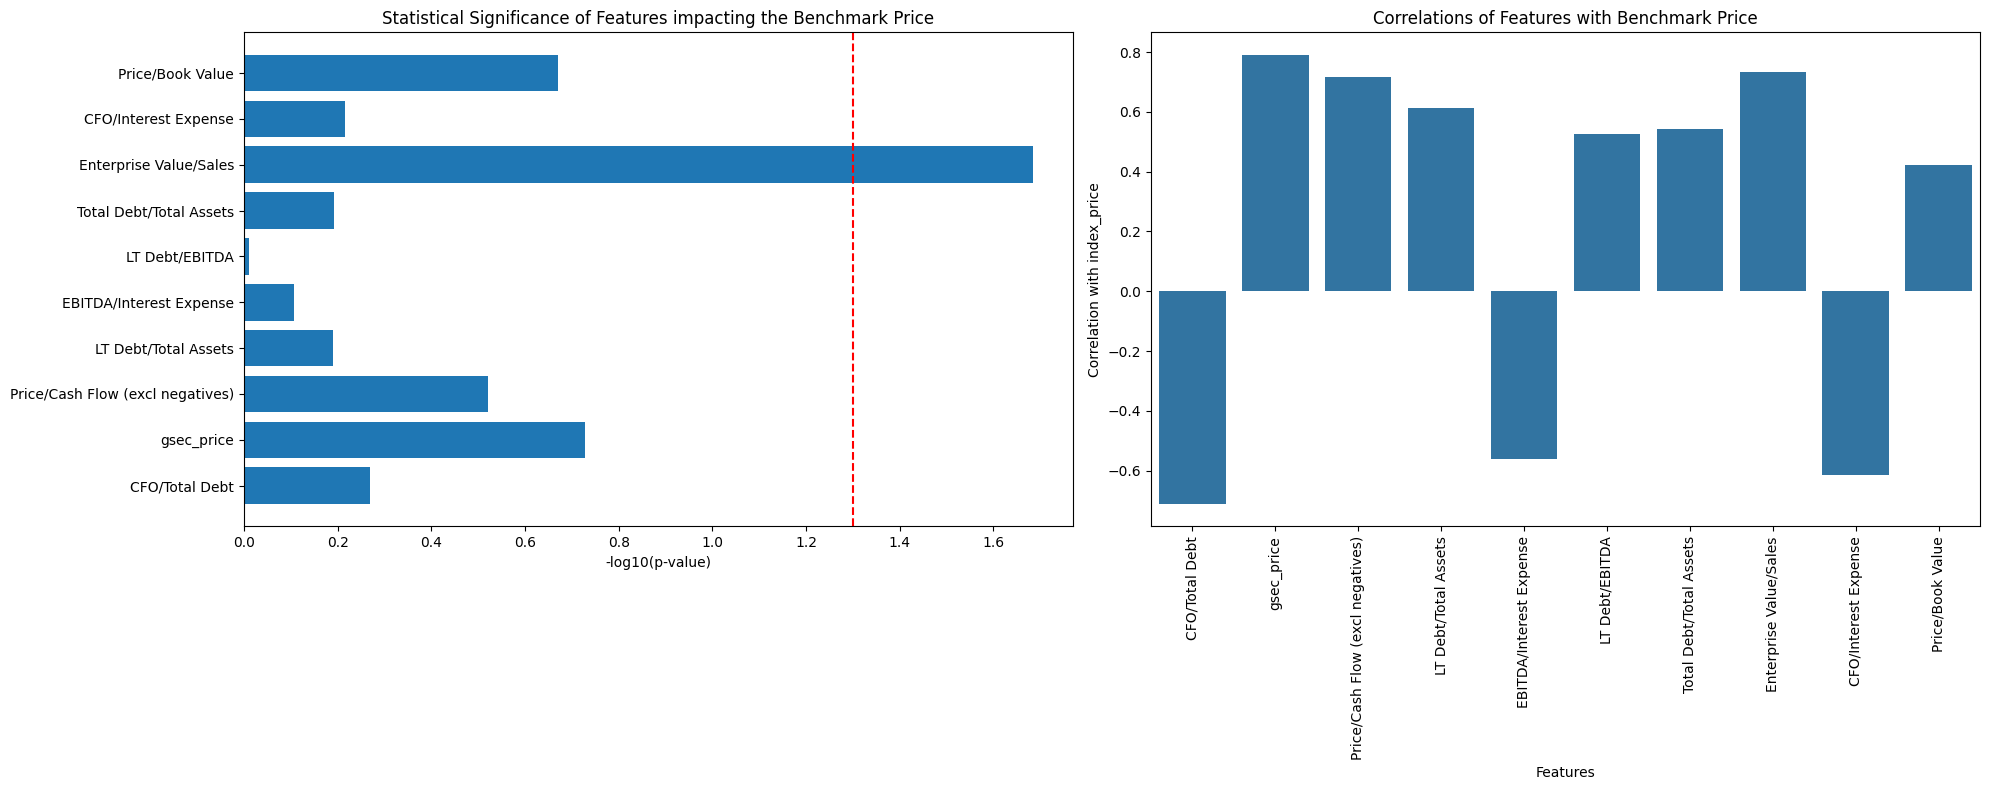

                            OLS Regression Results                            
Dep. Variable:        benchmark_price   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     20.82
Date:                Tue, 02 Jul 2024   Prob (F-statistic):           5.74e-09
Time:                        12:17:29   Log-Likelihood:                -292.19
No. Observations:                  33   AIC:                             606.4
Df Residuals:                      22   BIC:                             622.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame with relevant columns for OLS
df = pd.read_csv('updated_Japan_file.csv')

# Selecting relevant features for OLS
selected_features = ['CFO/Total Debt',
    'gsec_price',
    'Price/Cash Flow (excl negatives)',
    'LT Debt/Total Assets',
    'EBITDA/Interest Expense',
    'LT Debt/EBITDA',
    'Total Debt/Total Assets',
    'Enterprise Value/Sales',
    'CFO/Interest Expense',
    'Price/Book Value'
]
X = sm.add_constant(df[selected_features])  # Including intercept

# Target variable
y = df['benchmark_price']

# Fit OLS model
model = sm.OLS(y, X)
results = model.fit()

# Extract p-values
p_values = results.pvalues.drop('const')  # Excluding the intercept

# Compute correlations
correlations = df[selected_features].corrwith(df['benchmark_price'])

# Plot p-values and correlations side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot p-values
ax[0].barh(selected_features, -np.log10(p_values))
ax[0].set_xlabel('-log10(p-value)')
ax[0].set_title('Statistical Significance of Features impacting the Benchmark Price')
ax[0].axvline(x=-np.log10(0.05), color='red', linestyle='--')

# Plot correlations
sns.barplot(x=correlations.index, y=correlations.values, ax=ax[1])
ax[1].set_xlabel('Features')
ax[1].set_ylabel('Correlation with index_price')
ax[1].set_title('Correlations of Features with Benchmark Price')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.savefig('Statistical_Significance_and_Correlations.png', bbox_inches='tight')
plt.show()

# Print summary of regression results
print(results.summary())


c:\Users\valap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e+07, tolerance: 3.312e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\valap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\valap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.945e+07, tolerance: 3.759e+04
  model = cd_fast

Gradient Boosting Regressor:
Mean Absolute Error (MAE): 3028.0615464321904
R-squared (R2): 0.1657650046280107

Support Vector Regression (SVR):
Mean Absolute Error (MAE): 7992.366844953323
R-squared (R2): -3.2578374880050847

Ridge Regression:
Mean Absolute Error (MAE): 2797.543430716037
R-squared (R2): 0.30856626413791743

Lasso Regression:
Mean Absolute Error (MAE): 2413.329238683597
R-squared (R2): 0.3415511125165114



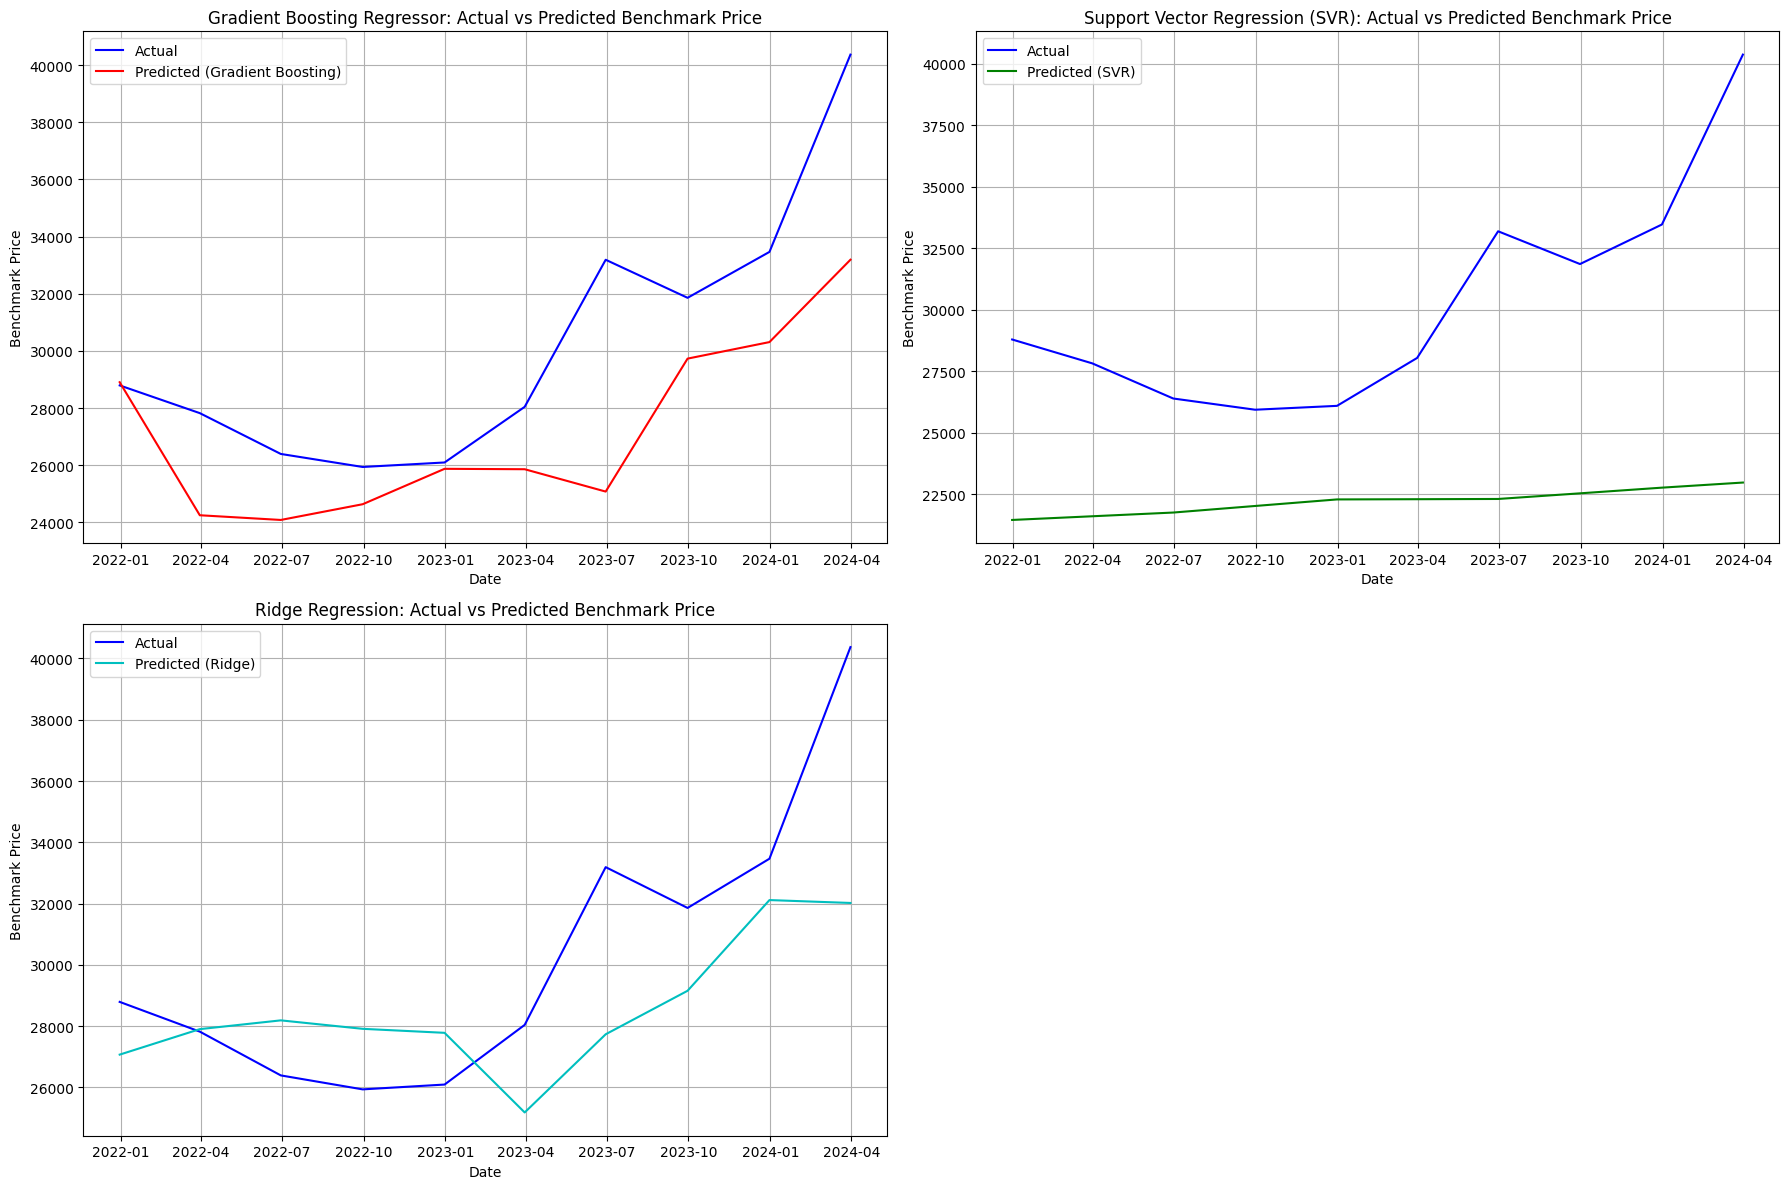

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset
data_path = 'updated_Japan_file.csv'
data = pd.read_csv(data_path)

# Ensure the data is sorted by 'quarter_date'
data.sort_values(by='quarter_date', inplace=True)

# Set the 'quarter_date' as the index (optional, but helps with plotting and indexing)
data['quarter_date'] = pd.to_datetime(data['quarter_date'])
data.set_index('quarter_date', inplace=True)

# Define features and target
features = [
    'CFO/Total Debt',
    'gsec_price',
    'Price/Cash Flow (excl negatives)',
    'LT Debt/Total Assets',
    'EBITDA/Interest Expense',
    'LT Debt/EBITDA',
    'Total Debt/Total Assets',
    'Enterprise Value/Sales',
    'CFO/Interest Expense',
    'Price/Book Value'
]
target = 'benchmark_price'

# Walk-forward validation
n_train = int(len(data) * 0.7)  # Use 70% of the data for training
X = data[features]
y = data[target]
predictions_gb = []
predictions_svr = []
predictions_ridge = []
predictions_lasso = []
predictions_nn = []
actuals = []

for i in range(n_train, len(data)):
    train = data.iloc[:i]
    test = data.iloc[i:i+1]
    
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
    
    # Gradient Boosting Regressor
    model_gb = GradientBoostingRegressor(random_state=42)
    model_gb.fit(X_train, y_train)
    pred_gb = model_gb.predict(X_test)
    predictions_gb.append(pred_gb[0])
    
    # Support Vector Regression (SVR)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model_svr = SVR(kernel='rbf')
    model_svr.fit(X_train_scaled, y_train)
    pred_svr = model_svr.predict(X_test_scaled)
    predictions_svr.append(pred_svr[0])
    
    # Ridge Regression
    model_ridge = Ridge(alpha=1.0)
    model_ridge.fit(X_train, y_train)
    pred_ridge = model_ridge.predict(X_test)
    predictions_ridge.append(pred_ridge[0])
    
    # Lasso Regression
    model_lasso = Lasso(alpha=0.1)
    model_lasso.fit(X_train, y_train)
    pred_lasso = model_lasso.predict(X_test)
    predictions_lasso.append(pred_lasso[0])
    
    # Neural Network (MLPRegressor)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model_nn = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    model_nn.fit(X_train_scaled, y_train)
    pred_nn = model_nn.predict(X_test_scaled)
    predictions_nn.append(pred_nn[0])
    
    actuals.append(y_test.values[0])

# Convert results to DataFrame for easy handling
results = pd.DataFrame({
    'date': data.index[n_train:],
    'actual': actuals,
    'predicted_gb': predictions_gb,
    'predicted_svr': predictions_svr,
    'predicted_ridge': predictions_ridge,
    'predicted_lasso': predictions_lasso,
    'predicted_nn': predictions_nn
}).set_index('date')

# Calculate MAE and R2 for each model
mae_gb = mean_absolute_error(results['actual'], results['predicted_gb'])
r2_gb = r2_score(results['actual'], results['predicted_gb'])

mae_svr = mean_absolute_error(results['actual'], results['predicted_svr'])
r2_svr = r2_score(results['actual'], results['predicted_svr'])

mae_ridge = mean_absolute_error(results['actual'], results['predicted_ridge'])
r2_ridge = r2_score(results['actual'], results['predicted_ridge'])

mae_lasso = mean_absolute_error(results['actual'], results['predicted_lasso'])
r2_lasso = r2_score(results['actual'], results['predicted_lasso'])

mae_nn = mean_absolute_error(results['actual'], results['predicted_nn'])
r2_nn = r2_score(results['actual'], results['predicted_nn'])

print('Gradient Boosting Regressor:')
print(f'Mean Absolute Error (MAE): {mae_gb}')
print(f'R-squared (R2): {r2_gb}')
print('')

print('Support Vector Regression (SVR):')
print(f'Mean Absolute Error (MAE): {mae_svr}')
print(f'R-squared (R2): {r2_svr}')
print('')

print('Ridge Regression:')
print(f'Mean Absolute Error (MAE): {mae_ridge}')
print(f'R-squared (R2): {r2_ridge}')
print('')

print('Lasso Regression:')
print(f'Mean Absolute Error (MAE): {mae_lasso}')
print(f'R-squared (R2): {r2_lasso}')
print('')

# Plotting actual vs predicted for each model
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(results.index, results['actual'], label='Actual', color='b')
plt.plot(results.index, results['predicted_gb'], label='Predicted (Gradient Boosting)', color='r')
plt.xlabel('Date')
plt.ylabel('Benchmark Price')
plt.title('Gradient Boosting Regressor: Actual vs Predicted Benchmark Price')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(results.index, results['actual'], label='Actual', color='b')
plt.plot(results.index, results['predicted_svr'], label='Predicted (SVR)', color='g')
plt.xlabel('Date')
plt.ylabel('Benchmark Price')
plt.title('Support Vector Regression (SVR): Actual vs Predicted Benchmark Price')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(results.index, results['actual'], label='Actual', color='b')
plt.plot(results.index, results['predicted_ridge'], label='Predicted (Ridge)', color='c')
plt.xlabel('Date')
plt.ylabel('Benchmark Price')
plt.title('Ridge Regression: Actual vs Predicted Benchmark Price')
plt.legend()
plt.grid(True)



plt.tight_layout()
plt.show()


c:\Users\valap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.623e+04, tolerance: 7.798e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\valap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\valap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.636e+04, tolerance: 9.377e+01
  model = cd_fast

Gradient Boosting Regressor:
Mean Absolute Error (MAE): 160.96599981689045
R-squared (R2): 0.5093674094924612

Support Vector Regression (SVR):
Mean Absolute Error (MAE): 660.8111478247748
R-squared (R2): -5.467296713231139

Ridge Regression:
Mean Absolute Error (MAE): 178.2389155894996
R-squared (R2): 0.3750508920126614

Lasso Regression:
Mean Absolute Error (MAE): 162.80901168322654
R-squared (R2): 0.5589650676034765



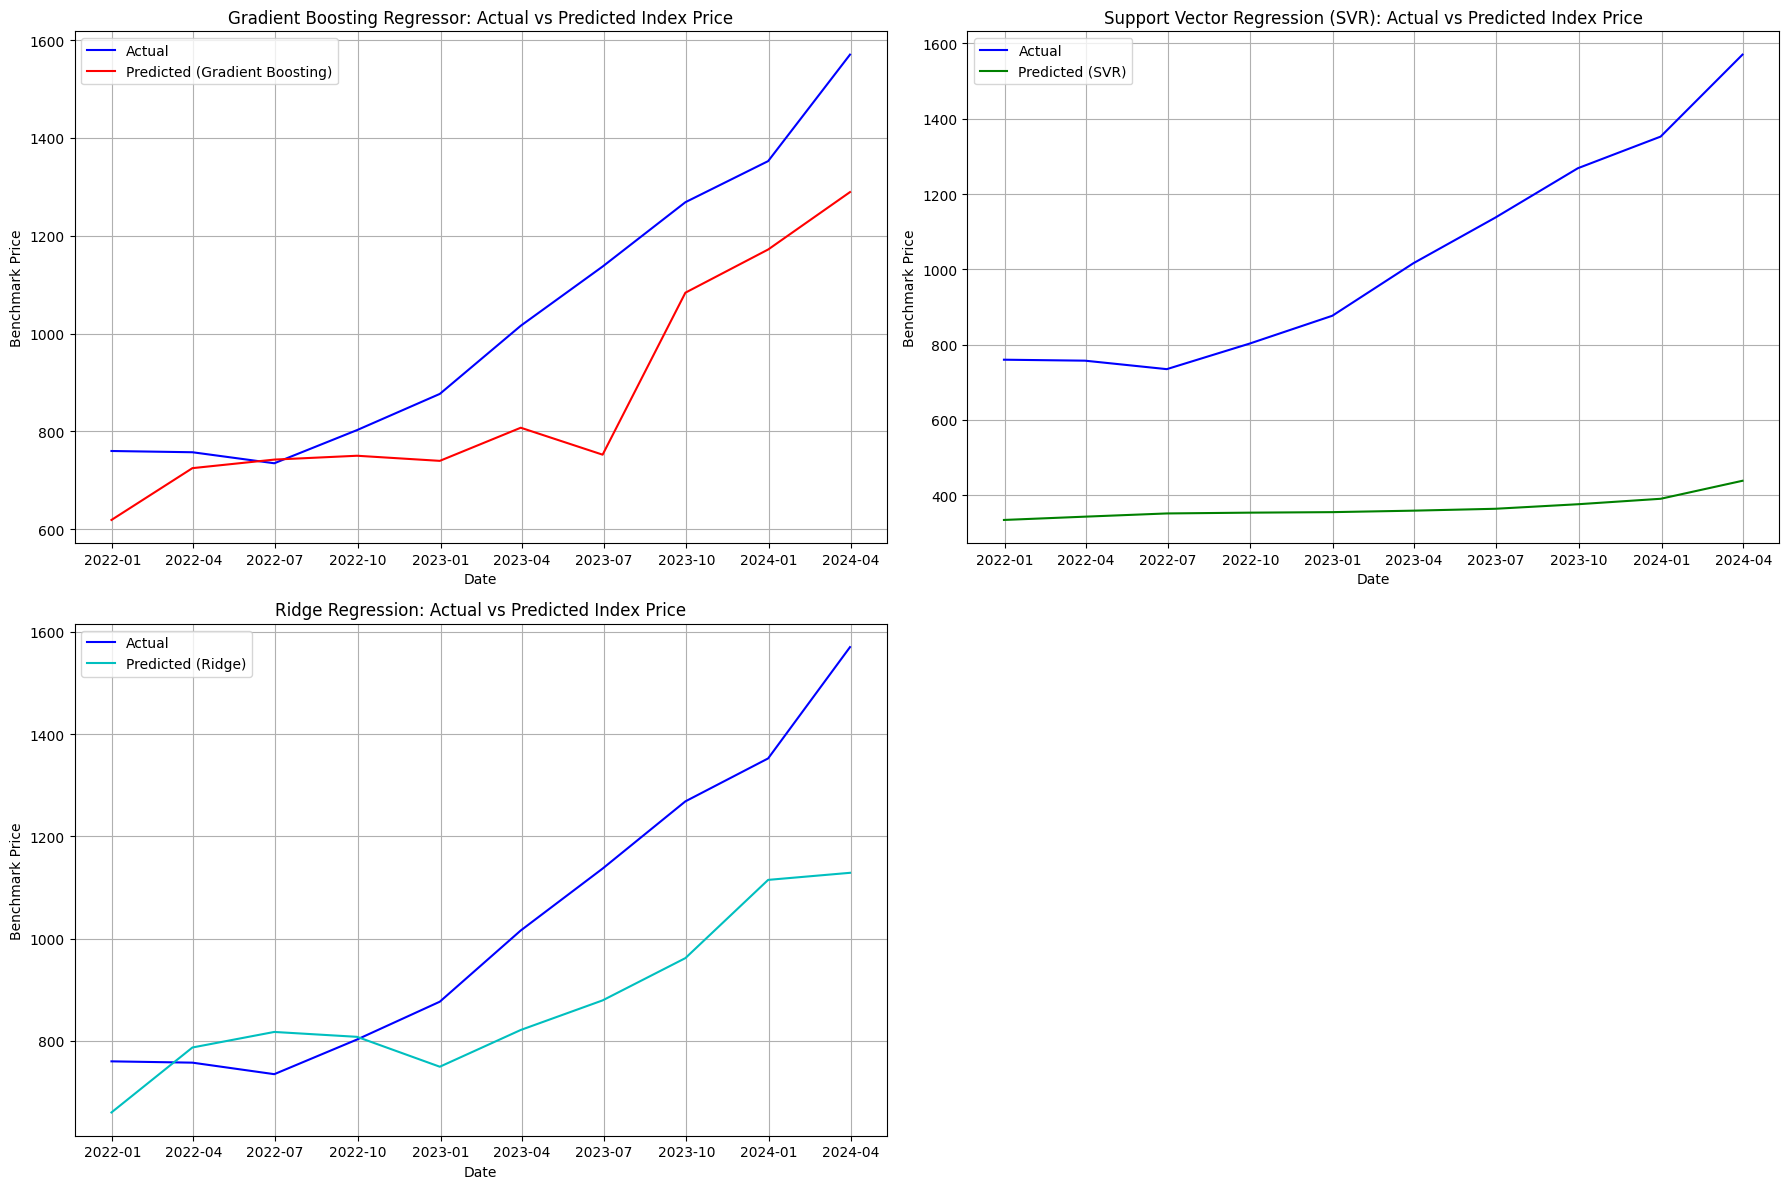

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset
data_path = 'updated_Japan_file.csv'
data = pd.read_csv(data_path)

# Ensure the data is sorted by 'quarter_date'
data.sort_values(by='quarter_date', inplace=True)

# Set the 'quarter_date' as the index (optional, but helps with plotting and indexing)
data['quarter_date'] = pd.to_datetime(data['quarter_date'])
data.set_index('quarter_date', inplace=True)

# Define features and target
features = [
    'CFO/Total Debt',
    'gsec_price',
    'CFO/Interest Expense',
    'Price/Cash Flow (excl negatives)',
    'LT Debt/Total Assets',
    'Total Debt/Total Assets',
    'EBITDA/Interest Expense',
    'LT Debt/EBITDA',
    'Total Debt/EBITDA',
    'cpi'
]
target = 'index_price'

# Walk-forward validation
n_train = int(len(data) * 0.7)  # Use 70% of the data for training
X = data[features]
y = data[target]
predictions_gb = []
predictions_svr = []
predictions_ridge = []
predictions_lasso = []
predictions_nn = []
actuals = []

for i in range(n_train, len(data)):
    train = data.iloc[:i]
    test = data.iloc[i:i+1]
    
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
    
    # Gradient Boosting Regressor
    model_gb = GradientBoostingRegressor(random_state=42)
    model_gb.fit(X_train, y_train)
    pred_gb = model_gb.predict(X_test)
    predictions_gb.append(pred_gb[0])
    
    # Support Vector Regression (SVR)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model_svr = SVR(kernel='rbf')
    model_svr.fit(X_train_scaled, y_train)
    pred_svr = model_svr.predict(X_test_scaled)
    predictions_svr.append(pred_svr[0])
    
    # Ridge Regression
    model_ridge = Ridge(alpha=1.0)
    model_ridge.fit(X_train, y_train)
    pred_ridge = model_ridge.predict(X_test)
    predictions_ridge.append(pred_ridge[0])
    
    # Lasso Regression
    model_lasso = Lasso(alpha=0.1)
    model_lasso.fit(X_train, y_train)
    pred_lasso = model_lasso.predict(X_test)
    predictions_lasso.append(pred_lasso[0])
    
    # Neural Network (MLPRegressor)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model_nn = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    model_nn.fit(X_train_scaled, y_train)
    pred_nn = model_nn.predict(X_test_scaled)
    predictions_nn.append(pred_nn[0])
    
    actuals.append(y_test.values[0])

# Convert results to DataFrame for easy handling
results = pd.DataFrame({
    'date': data.index[n_train:],
    'actual': actuals,
    'predicted_gb': predictions_gb,
    'predicted_svr': predictions_svr,
    'predicted_ridge': predictions_ridge,
    'predicted_lasso': predictions_lasso,
    'predicted_nn': predictions_nn
}).set_index('date')

# Calculate MAE and R2 for each model
mae_gb = mean_absolute_error(results['actual'], results['predicted_gb'])
r2_gb = r2_score(results['actual'], results['predicted_gb'])

mae_svr = mean_absolute_error(results['actual'], results['predicted_svr'])
r2_svr = r2_score(results['actual'], results['predicted_svr'])

mae_ridge = mean_absolute_error(results['actual'], results['predicted_ridge'])
r2_ridge = r2_score(results['actual'], results['predicted_ridge'])

mae_lasso = mean_absolute_error(results['actual'], results['predicted_lasso'])
r2_lasso = r2_score(results['actual'], results['predicted_lasso'])

mae_nn = mean_absolute_error(results['actual'], results['predicted_nn'])
r2_nn = r2_score(results['actual'], results['predicted_nn'])

print('Gradient Boosting Regressor:')
print(f'Mean Absolute Error (MAE): {mae_gb}')
print(f'R-squared (R2): {r2_gb}')
print('')

print('Support Vector Regression (SVR):')
print(f'Mean Absolute Error (MAE): {mae_svr}')
print(f'R-squared (R2): {r2_svr}')
print('')

print('Ridge Regression:')
print(f'Mean Absolute Error (MAE): {mae_ridge}')
print(f'R-squared (R2): {r2_ridge}')
print('')

print('Lasso Regression:')
print(f'Mean Absolute Error (MAE): {mae_lasso}')
print(f'R-squared (R2): {r2_lasso}')
print('')

# Plotting actual vs predicted for each model
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(results.index, results['actual'], label='Actual', color='b')
plt.plot(results.index, results['predicted_gb'], label='Predicted (Gradient Boosting)', color='r')
plt.xlabel('Date')
plt.ylabel('Benchmark Price')
plt.title('Gradient Boosting Regressor: Actual vs Predicted Index Price')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(results.index, results['actual'], label='Actual', color='b')
plt.plot(results.index, results['predicted_svr'], label='Predicted (SVR)', color='g')
plt.xlabel('Date')
plt.ylabel('Benchmark Price')
plt.title('Support Vector Regression (SVR): Actual vs Predicted Index Price')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(results.index, results['actual'], label='Actual', color='b')
plt.plot(results.index, results['predicted_ridge'], label='Predicted (Ridge)', color='c')
plt.xlabel('Date')
plt.ylabel('Benchmark Price')
plt.title('Ridge Regression: Actual vs Predicted Index Price')
plt.legend()
plt.grid(True)



plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'exceptions'